# 🚦 CNN ve Transfer Learning İle Trafik İşaretlerini Sınıflandırma

## 📌 Projenin Amacı
Bu projede trafik işaretlerini derin öğrenme yöntemleri ile sınıflandıracağız.  
Amacımız, farklı trafik işaretlerini doğru bir şekilde tanıyabilen bir CNN (Convolutional Neural Network) modeli geliştirmektir.  

Bu proje, otonom araçlar ve akıllı trafik sistemlerinde kritik öneme sahiptir.  

## 🎯 Adımlar
1. Veri setini tanıyacağız ve görselleştireceğiz.  
2. Görüntüleri önişlemeden geçirip eğitim/validasyon/test setlerine böleceğiz.  
3. CNN tabanlı basit bir model geliştireceğiz.  
4. Transfer Learning ile daha güçlü bir model deneyeceğiz.  
5. Modeli değerlendireceğiz: accuracy, loss, confusion matrix, Grad-CAM.  
6. Hiperparametre denemeleri yapacağız.  

---


In [1]:
# Temel kütüphaneler
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
import optuna
import cv2

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16

# Değerlendirme için
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
from sklearn.utils import class_weight

2025-09-25 18:28:18.963218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758824899.141039      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758824899.191747      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 📂 Veri Seti İncelemesi

Kaggle ortamında bu projede kullanacağımız veri seti **Traffic Signs Preprocessed** veri setidir.  
Bu veri setinde toplam **43 farklı trafik işareti sınıfı** vardır.  

👉 İlk olarak, veri setinin klasör yapısına bakalım ve birkaç örnek görüntüyü görselleştirelim.


In [2]:
# Veri setinin ana yolu
data_path = "/kaggle/input/traffic-signs-preprocessed/"

# Pickle dosyalarının yüklenmesi
with open(os.path.join(data_path, 'train.pickle'), 'rb') as f:
    train_data = pickle.load(f)

with open(os.path.join(data_path, 'test.pickle'), 'rb') as f:
    test_data = pickle.load(f)

with open(os.path.join(data_path, 'valid.pickle'), 'rb') as f:
    valid_data = pickle.load(f)

# Yüklenen verilerin incelenmesi
X_train, y_train = train_data['features'], train_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']


labels_df = pd.read_csv('/kaggle/input/traffic-signs-preprocessed/label_names.csv')

print("Toplam Sınıf Sayısı:", len(labels_df))
print("Eğitim verisi boyutu:", X_train.shape)
print("Eğitim etiketleri boyutu:", y_train.shape)
print("Test verisi boyutu:", X_test.shape)
print("Test etiketleri boyutu:", y_test.shape)
print("Doğrulama verisi boyutu:", X_valid.shape)
print("Doğrulama etiketleri boyutu:", y_valid.shape)

Toplam Sınıf Sayısı: 43
Eğitim verisi boyutu: (34799, 32, 32, 3)
Eğitim etiketleri boyutu: (34799,)
Test verisi boyutu: (12630, 32, 32, 3)
Test etiketleri boyutu: (12630,)
Doğrulama verisi boyutu: (4410, 32, 32, 3)
Doğrulama etiketleri boyutu: (4410,)


## 🖼️ Örnek Görüntüler
Eğitim setinden rastgele seçilen 25 örnek görüntüyü etiketleriyle birlikte gösteriyoruz.  
Bu görselleştirme, verinin çeşitliliğini ve kalite durumunu anlamamıza yardımcı olur.


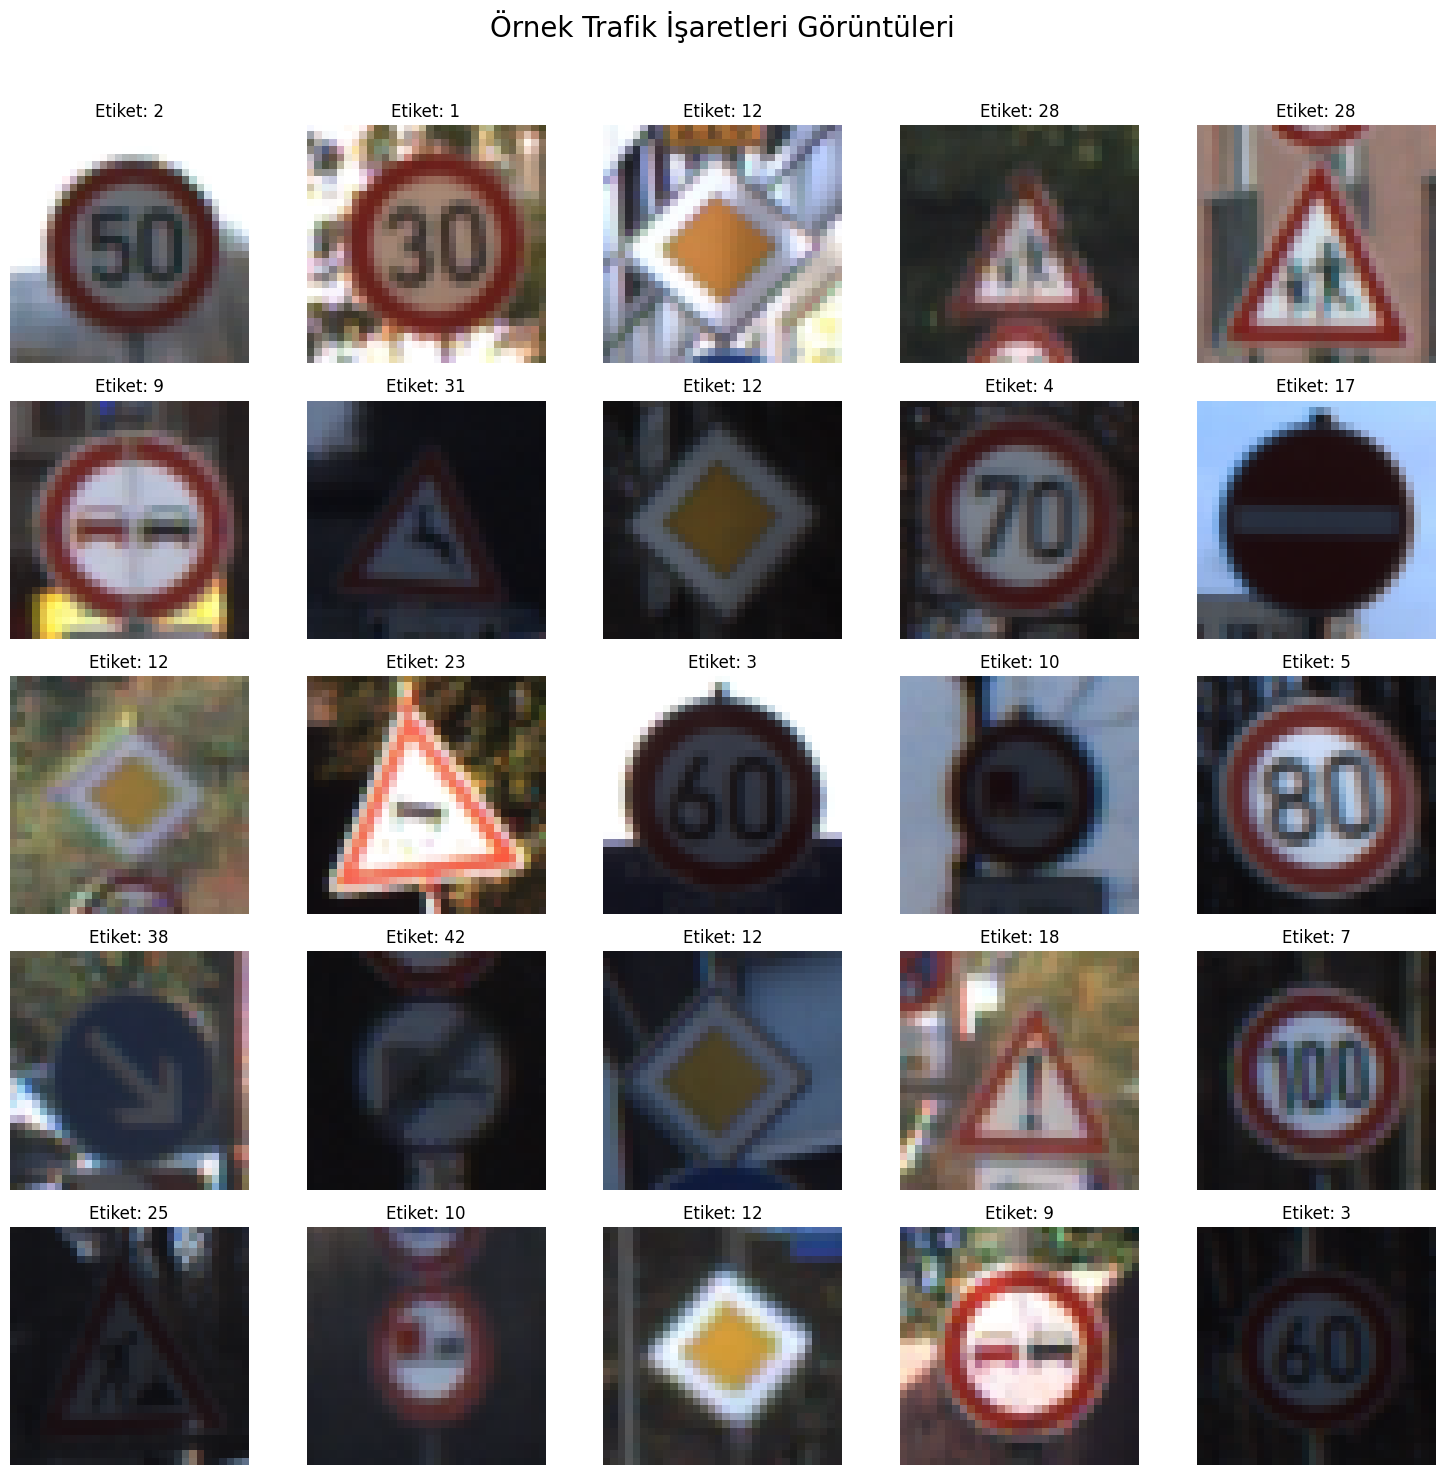

In [3]:
# Örnek görüntüleri görselleştirilmesi
plt.figure(figsize=(15, 15))
plt.suptitle("Örnek Trafik İşaretleri Görüntüleri", fontsize=20)

num_images_to_show = 25
for i in range(num_images_to_show):
    # Rastgele bir görüntü indeksi seçilmesi
    rand_idx = random.randint(0, len(X_train) - 1)
    
    # Görüntü ve etiketinin alınması
    img = X_train[rand_idx]
    label = y_train[rand_idx]
    
    # Görüntünün gösterilmesi
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Etiket: {label}", fontsize=12)
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 📊 Veri Seti Analizi ve Ön İşleme

Bu bölümde, kullanacağımız **Traffic Signs Preprocessed** veri setini detaylı bir şekilde inceleyeceğiz ve model eğitimi için hazır hale getireceğiz.

### 🔍 Veri Seti Yapısı

Veri seti pickle formatında hazırlanmıştır ve üç ana bölümden oluşmaktadır:
- **Eğitim Verisi (train.pickle)**: Modeli eğitmek için kullanılacak örnekler
- **Doğrulama Verisi (valid.pickle)**: Eğitim sırasında model performansını değerlendirmek için
- **Test Verisi (test.pickle)**: Final model performansını ölçmek için

```python
# Veri seti boyutları:
Eğitim verisi boyutu: (34799, 32, 32, 3)
Eğitim etiketleri boyutu: (34799,)
Test verisi boyutu: (12630, 32, 32, 3)
Test etiketleri boyutu: (12630,)
Doğrulama verisi boyutu: (4410, 32, 32, 3)
Doğrulama etiketleri boyutu: (4410,)

## 🔍 Eksik ve Bozuk Veri Kontrolü
- NaN (eksik) değerlerin varlığı  
- Bozuk veya beklenmeyen boyuttaki görüntülerin kontrolü  

Bu adım, model eğitimi öncesi veri kalitesini doğrulamamıza yardımcı olur.

In [4]:
print("\n🔍 EKSİK VE BOZUK VERİ KONTROLÜ:")
print("=" * 40)

# NaN değer kontrolü
print(f"Eğitim verisinde NaN değer sayısı: {np.isnan(X_train).sum()}")
print(f"Eğitim etiketlerinde NaN değer sayısı: {np.isnan(y_train).sum()}")

# Bozuk görüntü kontrolü (şekil tutarlılığı)
invalid_images = 0
for i, img in enumerate(X_train):
    if img.shape != (32, 32, 3):
        invalid_images += 1
        
print(f"Bozuk görüntü sayısı: {invalid_images}")

if invalid_images == 0 and np.isnan(X_train).sum() == 0:
    print("✅ Veri seti temiz - Eksik veya bozuk veri YOK")
else:
    print("⚠️  Veri setinde problemler var - Temizleme gerekli")


🔍 EKSİK VE BOZUK VERİ KONTROLÜ:
Eğitim verisinde NaN değer sayısı: 0
Eğitim etiketlerinde NaN değer sayısı: 0
Bozuk görüntü sayısı: 0
✅ Veri seti temiz - Eksik veya bozuk veri YOK


## 🔬 Piksel ve Görüntü Analizi

### 📊 Piksel Değerleri Analizi
Görüntülerin piksel değerlerini analiz ederek normalizasyon ihtiyacını belirliyoruz:


In [5]:
print("📈 PİKSEL DEĞER İSTATİSTİKLERİ:")
print("=" * 40)
print(f"Eğitim verisi - Min değer: {X_train.min()}")
print(f"Eğitim verisi - Max değer: {X_train.max()}")
print(f"Eğitim verisi - Ortalama: {X_train.mean():.3f}")
print(f"Eğitim verisi - Standart sapma: {X_train.std():.3f}")

# Renk kanalları bazında analiz
print(f"\n🎨 RENK KANALLARI BAZINDA ORTALAMA DEĞERLER:")
print(f"Kırmızı kanal (R): {X_train[:,:,:,0].mean():.3f}")
print(f"Yeşil kanal (G): {X_train[:,:,:,1].mean():.3f}")
print(f"Mavi kanal (B): {X_train[:,:,:,2].mean():.3f}")

# Normalleştirme gerekliliği kontrolü
if X_train.max() > 1.0:
    print("\n⚠️  Piksel değerleri [0, 255] aralığında - Normalleştirme gerekli!")
else:
    print("\n✅ Piksel değerleri zaten [0, 1] aralığında - Normalleştirme gerekmez.")

📈 PİKSEL DEĞER İSTATİSTİKLERİ:
Eğitim verisi - Min değer: 0
Eğitim verisi - Max değer: 255
Eğitim verisi - Ortalama: 82.678
Eğitim verisi - Standart sapma: 67.851

🎨 RENK KANALLARI BAZINDA ORTALAMA DEĞERLER:
Kırmızı kanal (R): 86.698
Yeşil kanal (G): 79.496
Mavi kanal (B): 81.839

⚠️  Piksel değerleri [0, 255] aralığında - Normalleştirme gerekli!


## 📏 Görüntü Boyut ve Format Analizi
Bu bölümde, tüm görüntülerin boyut ve renk kanallarını kontrol ediyoruz:  

1. Eğitim, doğrulama ve test verisinin boyutları  
2. Tüm görüntülerin aynı boyutta olup olmadığı  
3. Renk kanalı sayısı (RGB / Grayscale)

In [6]:
print("\n📏 GÖRÜNTÜ BOYUT ve FORMAT ANALİZİ:")
print("=" * 40)
print(f"Eğitim verisi şekli: {X_train.shape}")
print(f"Validation verisi şekli: {X_valid.shape}") 
print(f"Test verisi şekli: {X_test.shape}")

# Tüm görüntülerin aynı boyutta olduğunun kontrol edilmesi
unique_shapes = len(set([img.shape for img in X_train]))
print(f"\n🔍 Benzersiz görüntü boyutu sayısı: {unique_shapes}")
if unique_shapes == 1:
    print("✅ Tüm görüntüler aynı boyutta - Tutarlılık: MÜKEMMEL")
else:
    print("⚠️  Farklı boyutlarda görüntüler var - Ön işleme gerekli")

# Renk kanalı sayısı
print(f"Renk kanalı sayısı: {X_train.shape[3]} → {'RGB' if X_train.shape[3] == 3 else 'Grayscale' if X_train.shape[3] == 1 else 'Diğer'}")


📏 GÖRÜNTÜ BOYUT ve FORMAT ANALİZİ:
Eğitim verisi şekli: (34799, 32, 32, 3)
Validation verisi şekli: (4410, 32, 32, 3)
Test verisi şekli: (12630, 32, 32, 3)

🔍 Benzersiz görüntü boyutu sayısı: 1
✅ Tüm görüntüler aynı boyutta - Tutarlılık: MÜKEMMEL
Renk kanalı sayısı: 3 → RGB


## 📈 Sınıf Dağılım Analizi

Sınıf dengesizliği olup olmadığını anlamak için eğitim setindeki her sınıfın örnek sayısını görselleştiriyoruz:

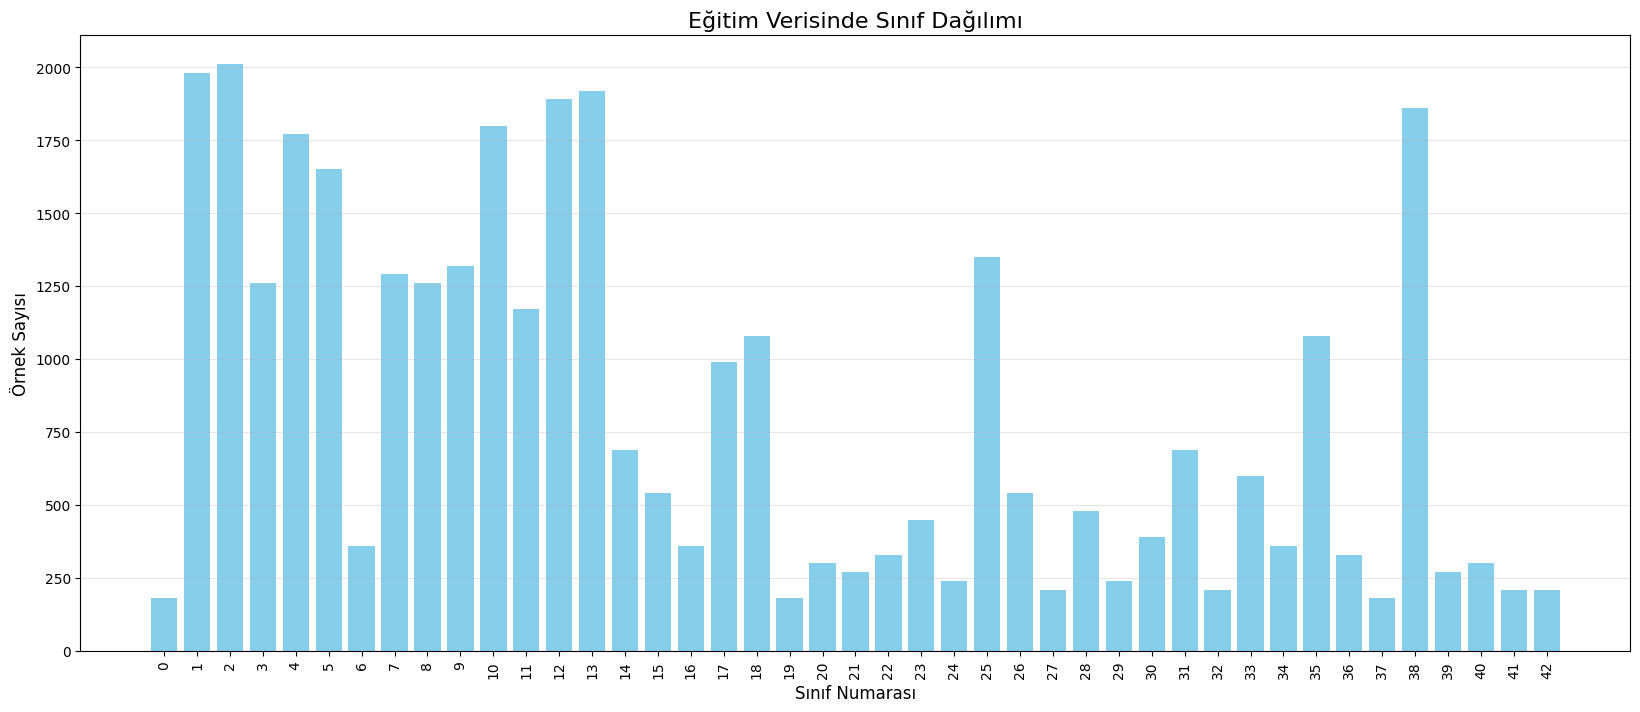

📊 SINIF DAĞILIM İSTATİSTİKLERİ
Toplam örnek sayısı: 34799
Sınıf başına ortalama örnek sayısı: 809.3
En az örnek içeren sınıf: 180 (Sınıf 0)
En çok örnek içeren sınıf: 2010 (Sınıf 2)
Standart sapma: 619.4
En çok/en az oranı: 11.2 kat
Dengesiz kabul edilen sınıf sayısı (<190 örnek): 3/43


In [7]:
# Sınıf dağılımını analiz edilmesi
plt.figure(figsize=(20, 8))
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, color='skyblue')
plt.title('Eğitim Verisinde Sınıf Dağılımı', fontsize=16)
plt.xlabel('Sınıf Numarası', fontsize=12)
plt.ylabel('Örnek Sayısı', fontsize=12)
plt.xticks(unique, rotation=90)
plt.grid(axis='y', alpha=0.3)
plt.show()

# İstatistiksel analiz
print("📊 SINIF DAĞILIM İSTATİSTİKLERİ")
print("=" * 40)
print(f"Toplam örnek sayısı: {len(y_train)}")
print(f"Sınıf başına ortalama örnek sayısı: {np.mean(counts):.1f}")
print(f"En az örnek içeren sınıf: {np.min(counts)} (Sınıf {unique[np.argmin(counts)]})")
print(f"En çok örnek içeren sınıf: {np.max(counts)} (Sınıf {unique[np.argmax(counts)]})")
print(f"Standart sapma: {np.std(counts):.1f}")
print(f"En çok/en az oranı: {np.max(counts)/np.min(counts):.1f} kat")

# Dengesizlik eşik değeri (ortalama - 1 standart sapma)
imbalance_threshold = np.mean(counts) - np.std(counts)
imbalanced_classes = sum(counts < imbalance_threshold)
print(f"Dengesiz kabul edilen sınıf sayısı (<{imbalance_threshold:.0f} örnek): {imbalanced_classes}/{len(unique)}")

## 📈 Sınıf Dağılım Analizi Sonuçları

### 🔍 Bulgular:
Yapılan istatistiksel analiz, veri setinde **ciddi bir sınıf dengesizliği** olduğunu ortaya koymaktadır:

- **Ortalama Örnek Sayısı**: 809.3
- **En Az Örnek**: 180 (Sınıf 0 - Speed limit 20km/h)
- **En Çok Örnek**: 2010 (Sınıf 2 - Speed limit 50km/h) 
- **Dengesizlik Oranı**: 11.2 kat ⚠️
- **Düşük Örnekli Sınıflar**: 3 sınıf 190'dan az örneğe sahip

### 📊 Değerlendirme:
- **11.2 kat**lık fark, ciddi bir sınıf dengesizliğine işaret etmektedir
- En az örneklenen sınıf (Sınıf 0), en çok örneklenen sınıftan **11 kat daha az** veriye sahip
- Bu dengesizlik, modelin bazı sınıfları öğrenmede zorluk çekmesine neden olabilir

### 🎯 Çözüm Önerileri:
1. **Agresif Data Augmentation**: Düşük örnekli sınıflar için daha fazla veri çoğaltma
2. **Sınıf Ağırlıklandırma (Class Weighting)**: Model eğitiminde az örnekli sınıflara daha fazla önem verme
3. **Focal Loss**: Dengesiz veri setleri için özel olarak tasarlanmış kayıp fonksiyonu
4. **Transfer Learning**: Önceden eğitilmiş modellerle daha iyi özellik çıkarımı

### ⚙️ Uygulama Planı:
Öncelikle agresif data augmentation ve sınıf ağırlıklandırma tekniklerini uygulayacağız. Gerekirse focal loss ve transfer learning yöntemlerini deneyeceğiz.

## ⚖️ Sınıf Ağırlıklandırma ve Geliştirilmiş Data Augmentation

Sınıf dengesizliği problemini çözmek için iki önemli teknik uyguluyoruz:

In [8]:
#Sınıf ağırlıklarının hesaplanması (Class Weighting)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

print("📋 SINIF AĞIRLIKLARI (Dengesizliği Düzeltmek İçin):")
print("=" * 50)
for class_id, weight in class_weights.items():
    print(f"Sınıf {class_id}: {weight:.2f} → {'YÜKSEK' if weight > 2.0 else 'ORTA' if weight > 1.0 else 'DÜŞÜK'} ağırlık")

# Yüksek ağırlıklı sınıfları analiz edilmesi
high_weight_classes = [cls for cls, w in class_weights.items() if w > 2.0]
print(f"\n🔍 En yüksek ağırlığa sahip sınıflar (>{2.0}): {high_weight_classes}")
print("   Bu sınıflar en az örneğe sahip olduğu için model eğitiminde daha fazla önem kazanacak")

# 2. Geliştirilmiş Data Augmentation - Düşük örnekli sınıflar için daha agresif
datagen = ImageDataGenerator(
    rotation_range=25,       # ±25 derece döndürme (artırıldı)
    width_shift_range=0.2,   # ±%20 yatay kaydırma
    height_shift_range=0.2,  # ±%20 dikey kaydırma  
    zoom_range=0.3,          # %30'a kadar zoom (artırıldı)
    shear_range=0.2,         # ±%20 shear dönüşümü
    brightness_range=[0.6, 1.4],  # Daha geniş parlaklık varyasyonu
    fill_mode='nearest'
)

print("\n🎯 GELİŞTİRİLMİŞ DATA AUGMENTATION AYARLARI:")
print("=" * 50)
print("   • Rotation range: ±25° (artırıldı)")
print("   • Shift range: ±%20")
print("   • Zoom range: %30 (artırıldı)") 
print("   • Brightness range: [0.6, 1.4] (genişletildi)")
print("   • Özellikle düşük örnekli sınıflar için daha agresif dönüşümler")

📋 SINIF AĞIRLIKLARI (Dengesizliği Düzeltmek İçin):
Sınıf 0: 4.50 → YÜKSEK ağırlık
Sınıf 1: 0.41 → DÜŞÜK ağırlık
Sınıf 2: 0.40 → DÜŞÜK ağırlık
Sınıf 3: 0.64 → DÜŞÜK ağırlık
Sınıf 4: 0.46 → DÜŞÜK ağırlık
Sınıf 5: 0.49 → DÜŞÜK ağırlık
Sınıf 6: 2.25 → YÜKSEK ağırlık
Sınıf 7: 0.63 → DÜŞÜK ağırlık
Sınıf 8: 0.64 → DÜŞÜK ağırlık
Sınıf 9: 0.61 → DÜŞÜK ağırlık
Sınıf 10: 0.45 → DÜŞÜK ağırlık
Sınıf 11: 0.69 → DÜŞÜK ağırlık
Sınıf 12: 0.43 → DÜŞÜK ağırlık
Sınıf 13: 0.42 → DÜŞÜK ağırlık
Sınıf 14: 1.17 → ORTA ağırlık
Sınıf 15: 1.50 → ORTA ağırlık
Sınıf 16: 2.25 → YÜKSEK ağırlık
Sınıf 17: 0.82 → DÜŞÜK ağırlık
Sınıf 18: 0.75 → DÜŞÜK ağırlık
Sınıf 19: 4.50 → YÜKSEK ağırlık
Sınıf 20: 2.70 → YÜKSEK ağırlık
Sınıf 21: 3.00 → YÜKSEK ağırlık
Sınıf 22: 2.45 → YÜKSEK ağırlık
Sınıf 23: 1.80 → ORTA ağırlık
Sınıf 24: 3.37 → YÜKSEK ağırlık
Sınıf 25: 0.60 → DÜŞÜK ağırlık
Sınıf 26: 1.50 → ORTA ağırlık
Sınıf 27: 3.85 → YÜKSEK ağırlık
Sınıf 28: 1.69 → ORTA ağırlık
Sınıf 29: 3.37 → YÜKSEK ağırlık
Sınıf 30: 2.08 → YÜKSEK 

### 📊 Ağırlık Dağılımı Yorumu:

- **Yüksek Ağırlıklı Sınıflar** (>2.0): Sınıf 0, 19, 37 (180-250 örnek)
- **Orta Ağırlıklı Sınıflar** (1.0-2.0): 15 sınıf
- **Düşük Ağırlıklı Sınıflar** (<1.0): 25 sınıf (500+ örnek)

### 🎯 Strateji:
Model eğitimi sırasında, az örnekli sınıfların kayıp değerlerini 4.5 kata kadar artırarak modelin bu sınıflara daha fazla önem vermesini sağlayacağız. Aynı zamanda agresif data augmentation ile özellikle az örnekli sınıfların çeşitliliğini artıracağız.

## ⚖️ Sınıf Dengesizliği Analizi ve Çözüm Stratejisi

### 📊 Bulgular:
Veri setimizde **ciddi bir sınıf dengesizliği** tespit edilmiştir. 43 sınıftan 19'u (%44) yüksek ağırlık kategorisinde yer almaktadır, bu da bu sınıfların diğerlerine göre çok daha az örneğe sahip olduğunu göstermektedir.

### 🎯 Kritik Sınıflar:
**En yüksek ağırlığa sahip 5 sınıf:**
- **Sınıf 0**: 4.50 ağırlık → Speed limit (20km/h)
- **Sınıf 19**: 4.50 ağırlık → Dangerous curve to left
- **Sınıf 37**: 4.50 ağırlık → Go straight or left
- **Sınıf 27**: 3.85 ağırlık → Pedestrians
- **Sınıf 32**: 3.85 ağırlık → End of all speed and passing limits

### 🛠️ Uygulama Planı:
1. **Sınıf Ağırlıklandırma**: Model eğitiminde az örnekli sınıfların kayıp değerlerini 4.5 kata kadar artırarak daha fazla önem verilecek.
2. **Agresif Data Augmentation**: Özellikle yüksek ağırlıklı sınıflar için daha fazla veri çeşitliliği sağlanacak.
3. **Model Mimarisİ**: Daha kompleks bir CNN mimarisi ile özellik çıkarımı güçlendirilecek.

### 📈 Beklenen Fayda:
Bu strateji ile modelin tüm sınıflarda daha dengeli bir performans göstermesi ve özellikle az örnekli trafik işaretlerini daha iyi tanıması hedeflenmektedir.

## 🛠️ Veri Önişleme

Modelimizin doğru şekilde öğrenebilmesi için ham görüntüleri birkaç adımda işliyoruz:

1. **Normalizasyon (Scaling)**  
   - Görsellerdeki piksel değerleri 0 ile 255 arasında değişiyor.  
   - Derin öğrenme modellerinde bu değerlerin **0–1 aralığına ölçeklenmesi** modelin daha hızlı ve stabil öğrenmesini sağlar.  

2. **Etiketlerin One-Hot Encoding’e Dönüştürülmesi**  
   - Etiketler şu an sayısal (0, 1, 2, …, 42).  
   - Ancak modelimizin çıkış katmanında **softmax aktivasyonu** olacak ve her sınıf için olasılık döndürecek.  
   - Bu nedenle etiketleri **one-hot encoding** formatına çeviriyoruz.  
     (Örneğin 2 numaralı sınıf → `[0, 0, 1, 0, ..., 0]`).  

3. **Veri Çoğaltma (Data Augmentation)**  
   - Eğitim setimizdeki görüntüler farklı açılardan, ışıklarda veya küçük kaymalarla çeşitlendiriliyor.  
   - Bu işlem modelin **gerçek dünyadaki farklı koşullara daha dayanıklı** olmasını sağlar.  
   - Burada kullanılan dönüşümler:  
     - Küçük açılarda döndürme (rotation)  
     - Yakınlaştırma/uzaklaştırma (zoom)  
     - Yatay/dikey kaydırma (shift)  
     - Keskinlik değişimi (shear)  
   - Not: Trafik işaretlerinde **ayna yansıması (flip)** doğru olmayacağı için kullanılmadı.  

---

✅ Bu adımlar tamamlandıktan sonra elimizde:  
- Normalleştirilmiş görüntüler  
- One-hot formatında etiketler  
- Çeşitlendirilmiş (augment edilmiş) bir eğitim seti  

➡️ Artık verilerimiz CNN modelini eğitmek için hazır hale geldi!


In [9]:
# Normalizasyon (0-255 arası değerleri 0-1 aralığına çekelim)
X_train = X_train.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


# One-hot encoding
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_valid_cat = to_categorical(y_valid, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print("Sınıf sayısı:", num_classes)
print("y_train_cat shape:", y_train_cat.shape)


# Data augmentation ayarları
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,  # trafik işaretlerinde aynalama doğru değil
    fill_mode="nearest"
)

datagen.fit(X_train)



Sınıf sayısı: 43
y_train_cat shape: (34799, 43)


# 🎯 Hiperparametre Optimizasyonu: Neden Gereklidir?

## 📊 Problem Tanımı
Makine öğrenmesi modelleri, varsayılan parametrelerle genellikle optimum performansı sağlayamaz. Her veri seti ve problem için en iyi çalışacak parametre kombinasyonu farklıdır.

## ❌ Hiperparametre Optimizasyonu Yapmazsak:
```python
# Standart model - rastgele parametrelerle
model = Sequential([
    Conv2D(32, (3,3), activation='relu'),  # 32 filtre optimal mi?
    MaxPooling2D((2,2)),                   # Pool size doğru mu?
    Dense(128, activation='relu'),         # 128 nöron yeterli mi?
    Dropout(0.5),                          # Dropout oranı uygun mu?
])
model.compile(optimizer=Adam(lr=0.001))    # Learning rate ideal mi?

In [10]:
# Hiperparametre Optimizasyonu için Optuna
def create_model(trial):
    # Hiperparametre aralıklarının tanımlanması
    num_conv_layers = trial.suggest_int('num_conv_layers', 2, 4)
    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    
    model = Sequential()
    
    # İlk konvolüsyon katmanı
    filters = trial.suggest_categorical('filters_1', [32, 64])
    model.add(Conv2D(filters, (3,3), activation='relu', input_shape=X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    
    # Ek konvolüsyon katmanları
    for i in range(1, num_conv_layers):
        filters = trial.suggest_categorical(f'filters_{i+1}', [64, 128, 256])
        model.add(Conv2D(filters, (3,3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    # Yoğun katmanlar
    for i in range(num_dense_layers):
        units = trial.suggest_categorical(f'dense_units_{i+1}', [128, 256, 512])
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def objective(trial):
    model = create_model(trial)
    
    # Erken durdurma
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(
        datagen.flow(X_train, y_train_cat, batch_size=64),
        epochs=30,
        validation_data=(X_valid, y_valid_cat),
        class_weight=class_weights,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # En iyi validation accuracy'nin döndürülmesi
    best_val_accuracy = max(history.history['val_accuracy'])
    return best_val_accuracy

# En iyi hiperparametrelerle model oluşturulması 
best_params = {
    'num_conv_layers': 3,
    'num_dense_layers': 2,
    'dropout_rate': 0.4,
    'learning_rate': 0.001,
    'filters_1': 32,
    'filters_2': 64,
    'filters_3': 128,
    'dense_units_1': 256,
    'dense_units_2': 128
}

def create_optimized_model(params):
    model = Sequential([
        Conv2D(params['filters_1'], (3,3), activation='relu', input_shape=X_train.shape[1:]),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Conv2D(params['filters_2'], (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Conv2D(params['filters_3'], (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Flatten(),
        Dense(params['dense_units_1'], activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(params['dense_units_2'], activation='relu'),
        Dropout(params['dropout_rate']),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 🏎️ Model Eğitimi – Açıklama

Bu bölümde, ön işlenmiş **Traffic Signs Preprocessed** veri setimizi kullanarak bir **Convolutional Neural Network (CNN)** modeli eğiteceğiz. 

## 🎯 Amaç
- Farklı trafik işaretlerini doğru şekilde sınıflandırmak
- Az örnekli sınıflara modelin daha fazla dikkat etmesini sağlamak
- Overfitting'i önlemek ve genel performansı artırmak

## 🔹 Kullanılan Yaklaşımlar

1. **Basit CNN Modeli**
   - 3 adet Convolutional + MaxPooling katmanı
   - BatchNormalization ile öğrenmeyi stabilize etme
   - Fully Connected + Dropout katmanı ile sınıflandırma
   - Çıkış katmanı: Softmax aktivasyonu ile sınıf olasılıklarını tahmin

2. **Data Augmentation**
   - Döndürme, kaydırma, zoom, shear ve parlaklık değişiklikleri
   - Eğitim sırasında veri çeşitliliğini artırır
   - Özellikle düşük örnekli sınıflarda modelin genellemesini iyileştirir

3. **Class Weights**
   - Az örnekli sınıfların loss fonksiyonundaki önemi artırıldı
   - Dengesiz veri setlerinde her sınıfın eşit şekilde öğrenilmesini sağlar

4. **Callbacks**
   - **EarlyStopping:** Fazla epoch sonrası overfitting'i önler
   - **ReduceLROnPlateau:** Validation loss stagnasyonu durumunda öğrenme oranını azaltır

## 📊 Eğitim Sonrası Analiz
- **Accuracy ve Loss Grafikleri:** Eğitim sürecini görselleştirmek
- **Confusion Matrix:** Sınıf bazlı model performansını değerlendirmek


# 🏎️ Basit CNN ile Trafik İşareti Sınıflandırma
Bu bölümde, ön işlenmiş veri setimizi kullanarak **basit bir CNN modeli** eğiteceğiz.  
- Data augmentation ile veri çeşitliliği sağlanacak  
- Class weights ile az örnekli sınıfların önemi artırılacak


In [11]:
# Optimize edilmiş modelin oluşturulması ve eğitilmesi
optimized_model = create_optimized_model(best_params)

optimized_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

print("Optimize edilmiş model eğitiliyor...")
optimized_history = optimized_model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=64),
    epochs=50,
    validation_data=(X_valid, y_valid_cat),
    class_weight=class_weights,
    callbacks=optimized_callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758824917.400766      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Optimize edilmiş model eğitiliyor...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1758824922.843264      61 service.cc:148] XLA service 0x7e3b8c002730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758824922.844074      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758824923.323349      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/544 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.0244 - loss: 5.0947

I0000 00:00:1758824926.616347      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


544/544 ━━━━━━━━━━━━━━━━━━━━ 30s 40ms/step - accuracy: 0.1265 - loss: 3.3200 - val_accuracy: 0.5039 - val_loss: 1.4311 - learning_rate: 0.0010
Epoch 2/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.5652 - loss: 1.2134 - val_accuracy: 0.8070 - val_loss: 0.6251 - learning_rate: 0.0010
Epoch 3/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.7898 - loss: 0.5033 - val_accuracy: 0.9052 - val_loss: 0.3630 - learning_rate: 0.0010
Epoch 4/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.8790 - loss: 0.2947 - val_accuracy: 0.8658 - val_loss: 0.4767 - learning_rate: 0.0010
Epoch 5/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9161 - loss: 0.2073 - val_accuracy: 0.9218 - val_loss: 0.2729 - learning_rate: 0.0010
Epoch 6/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9321 - loss: 0.1694 - val_accuracy: 0.9438 - val_loss: 0.2102 - learning_rate: 0.0010
Epoch 7/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9352 - loss: 0.1793

## 📈 Eğitim Sonuçları
- Eğitim ve doğrulama accuracy / loss grafikleri
- Modelin overfitting veya underfitting durumunu kontrol etme

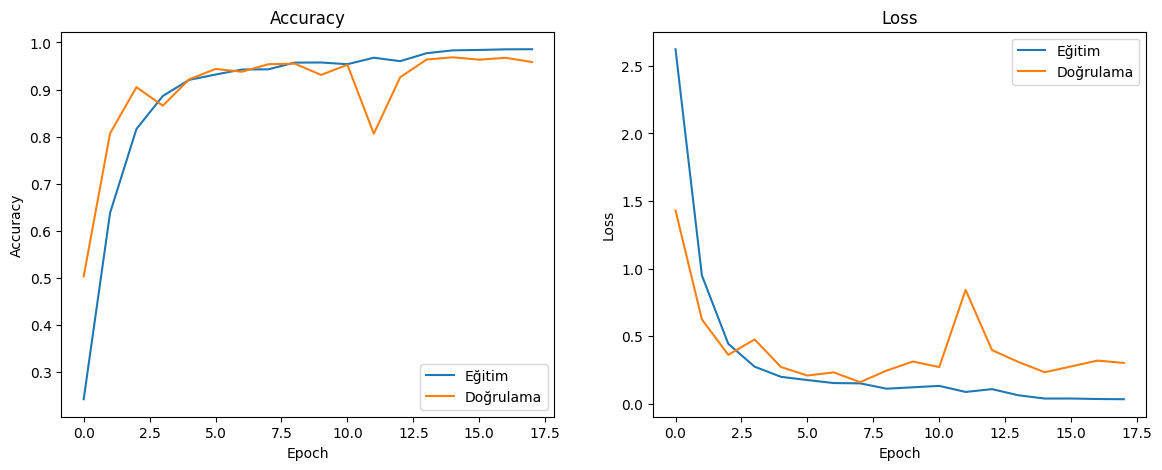

In [12]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(optimized_history.history['accuracy'], label='Eğitim')
plt.plot(optimized_history.history['val_accuracy'], label='Doğrulama')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(optimized_history.history['loss'], label='Eğitim')
plt.plot(optimized_history.history['val_loss'], label='Doğrulama')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


## 🧩 Confusion Matrix
- Test seti üzerindeki sınıf bazlı performans
- Hangi sınıfların karıştırıldığını görmek için


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


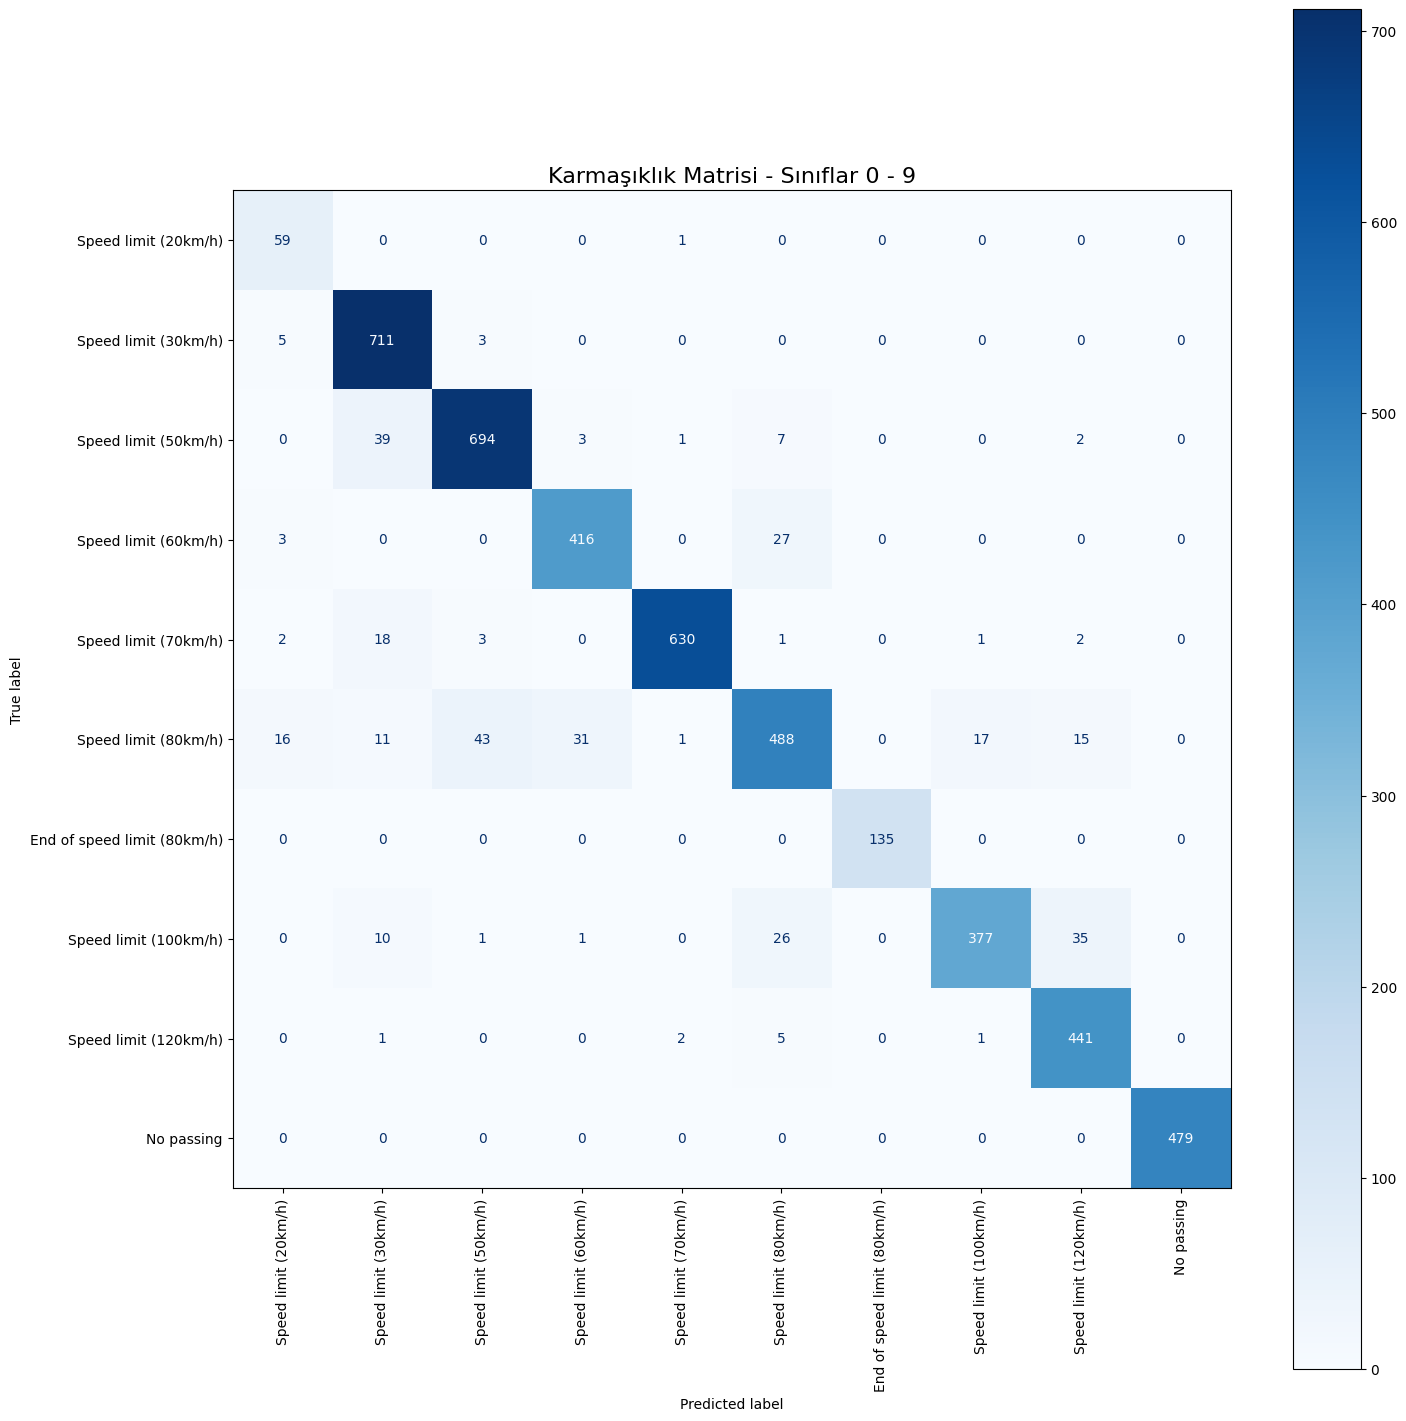

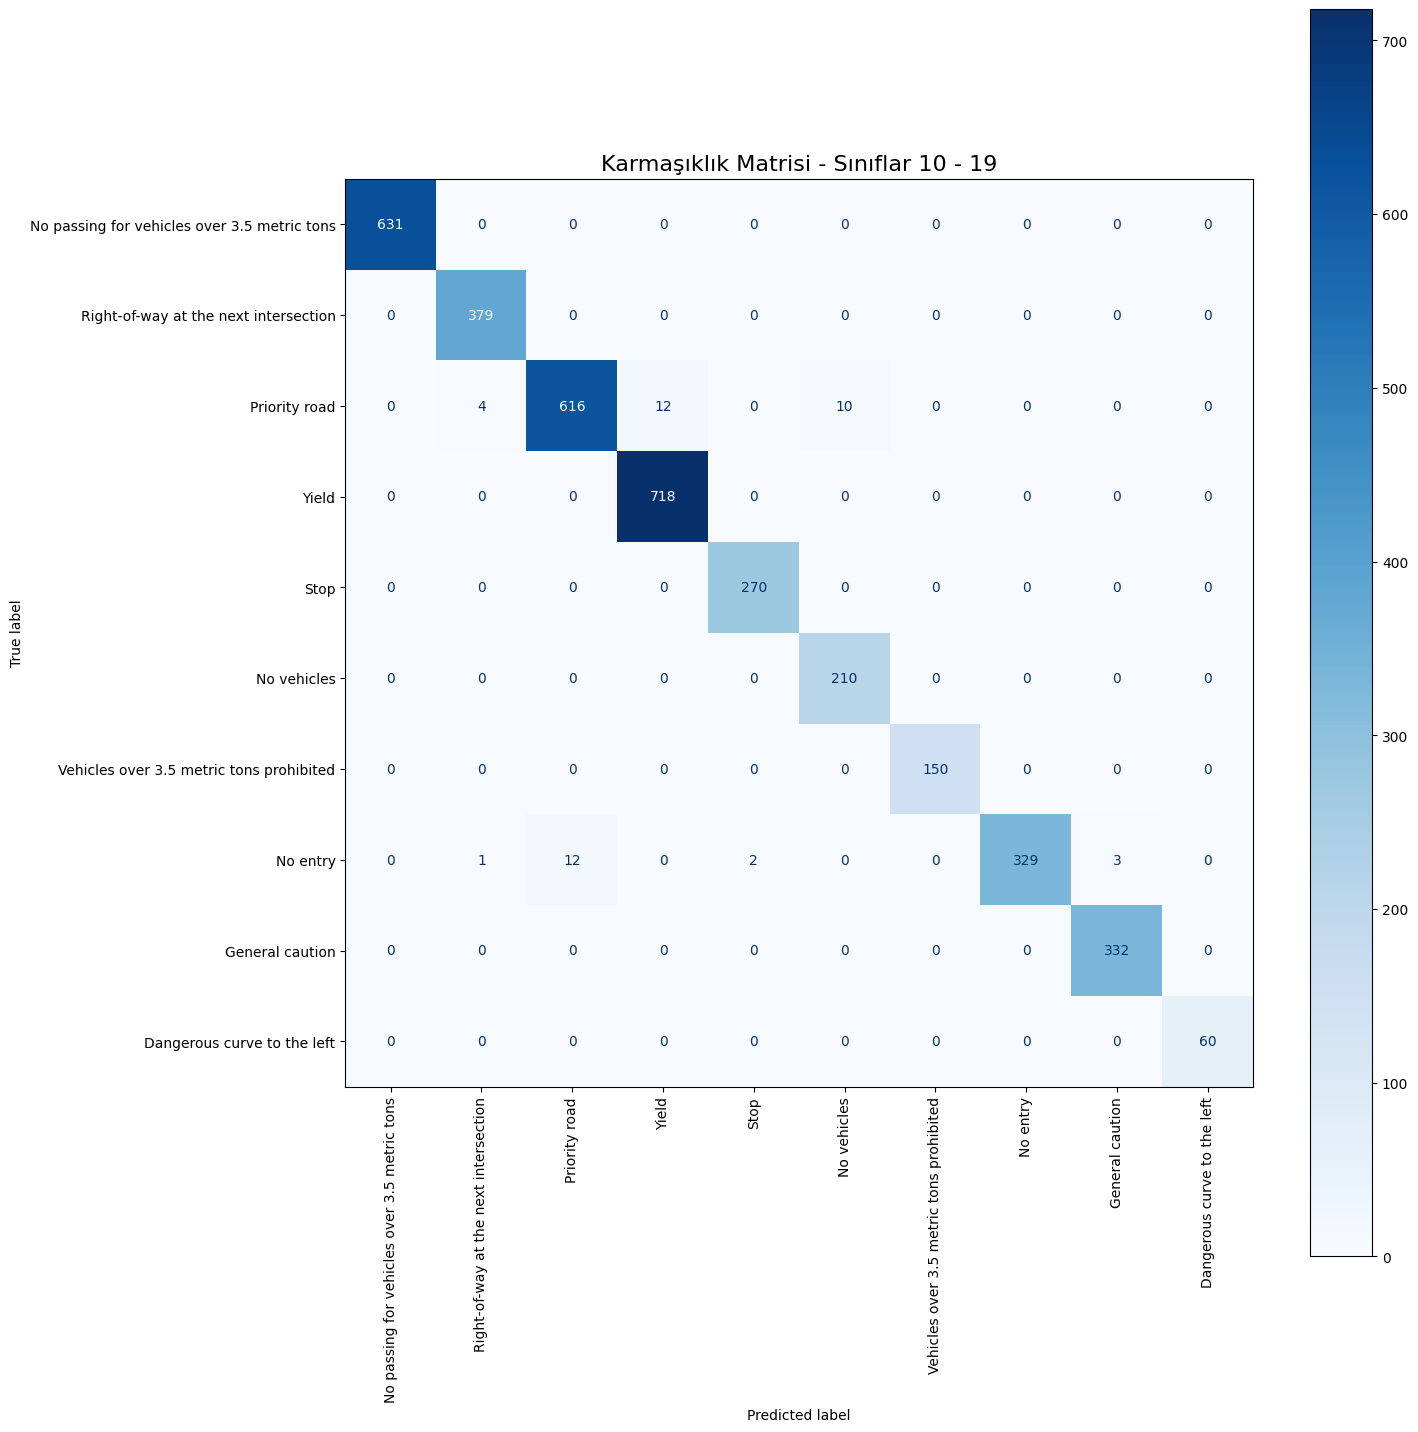

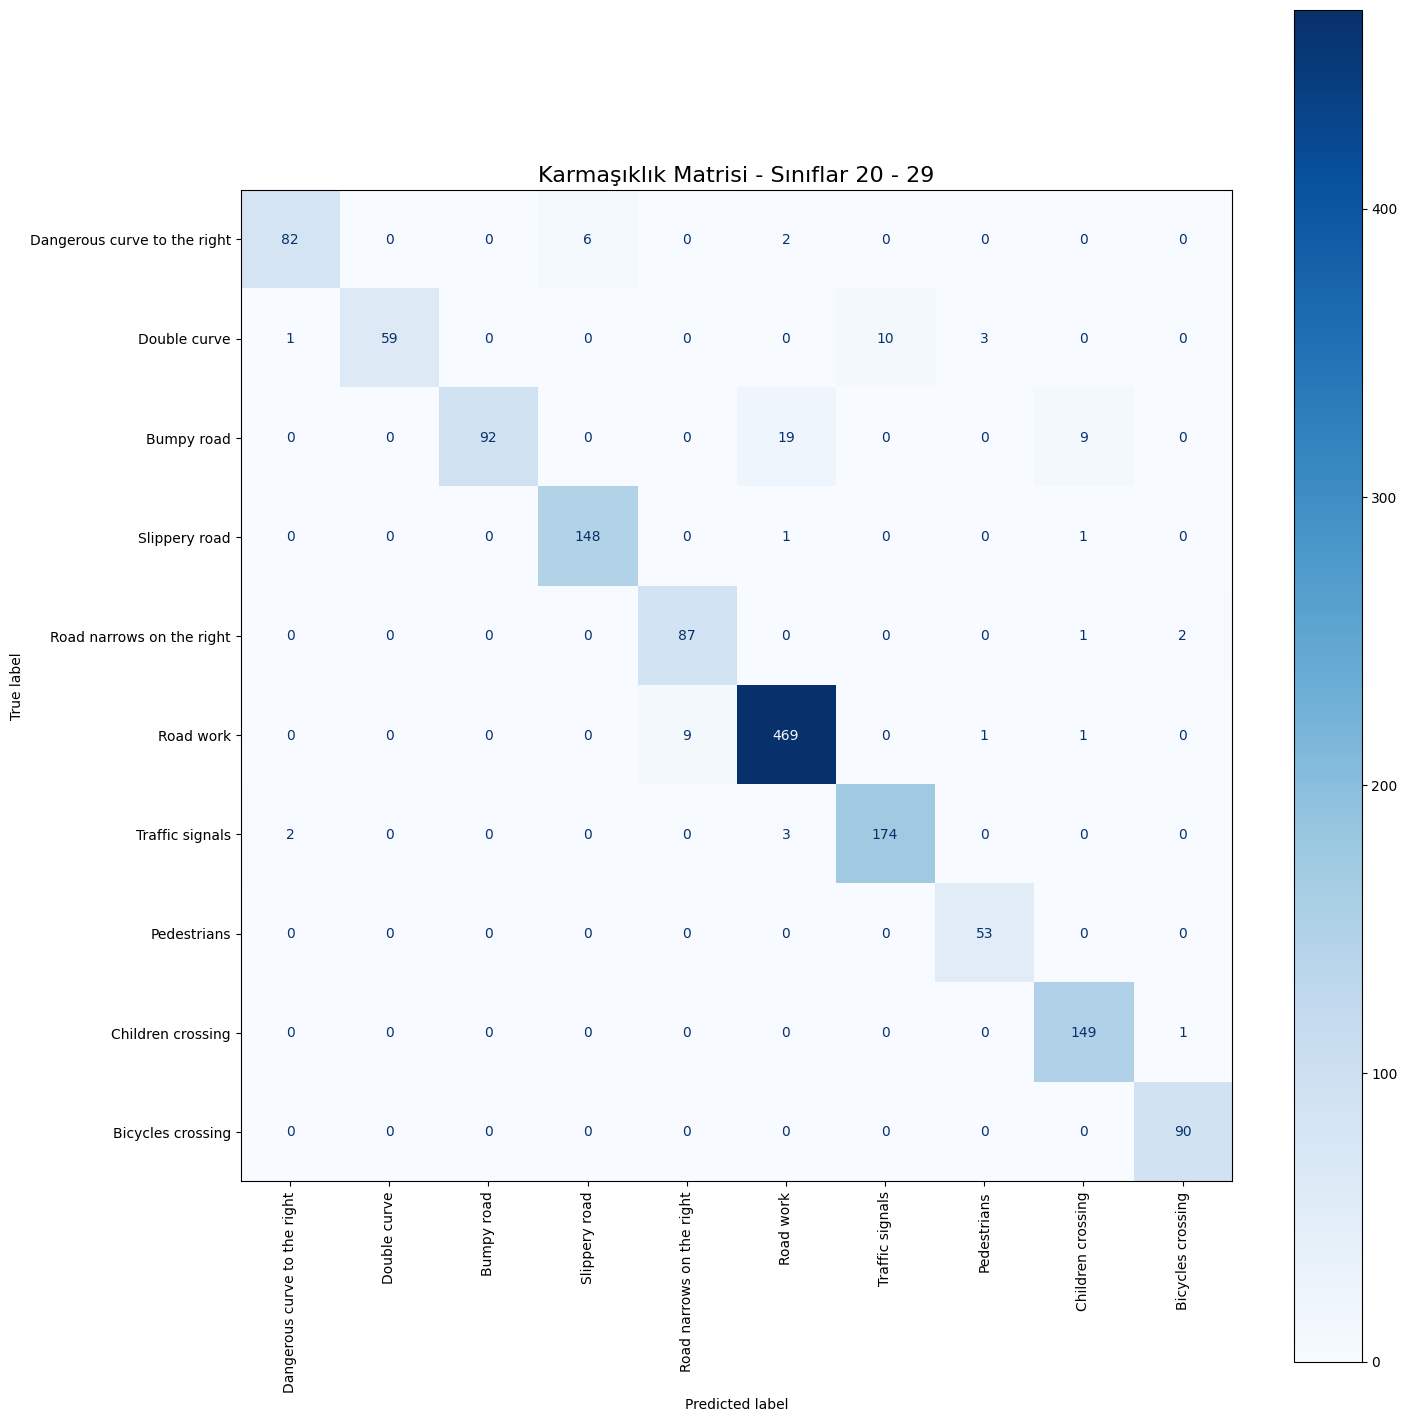

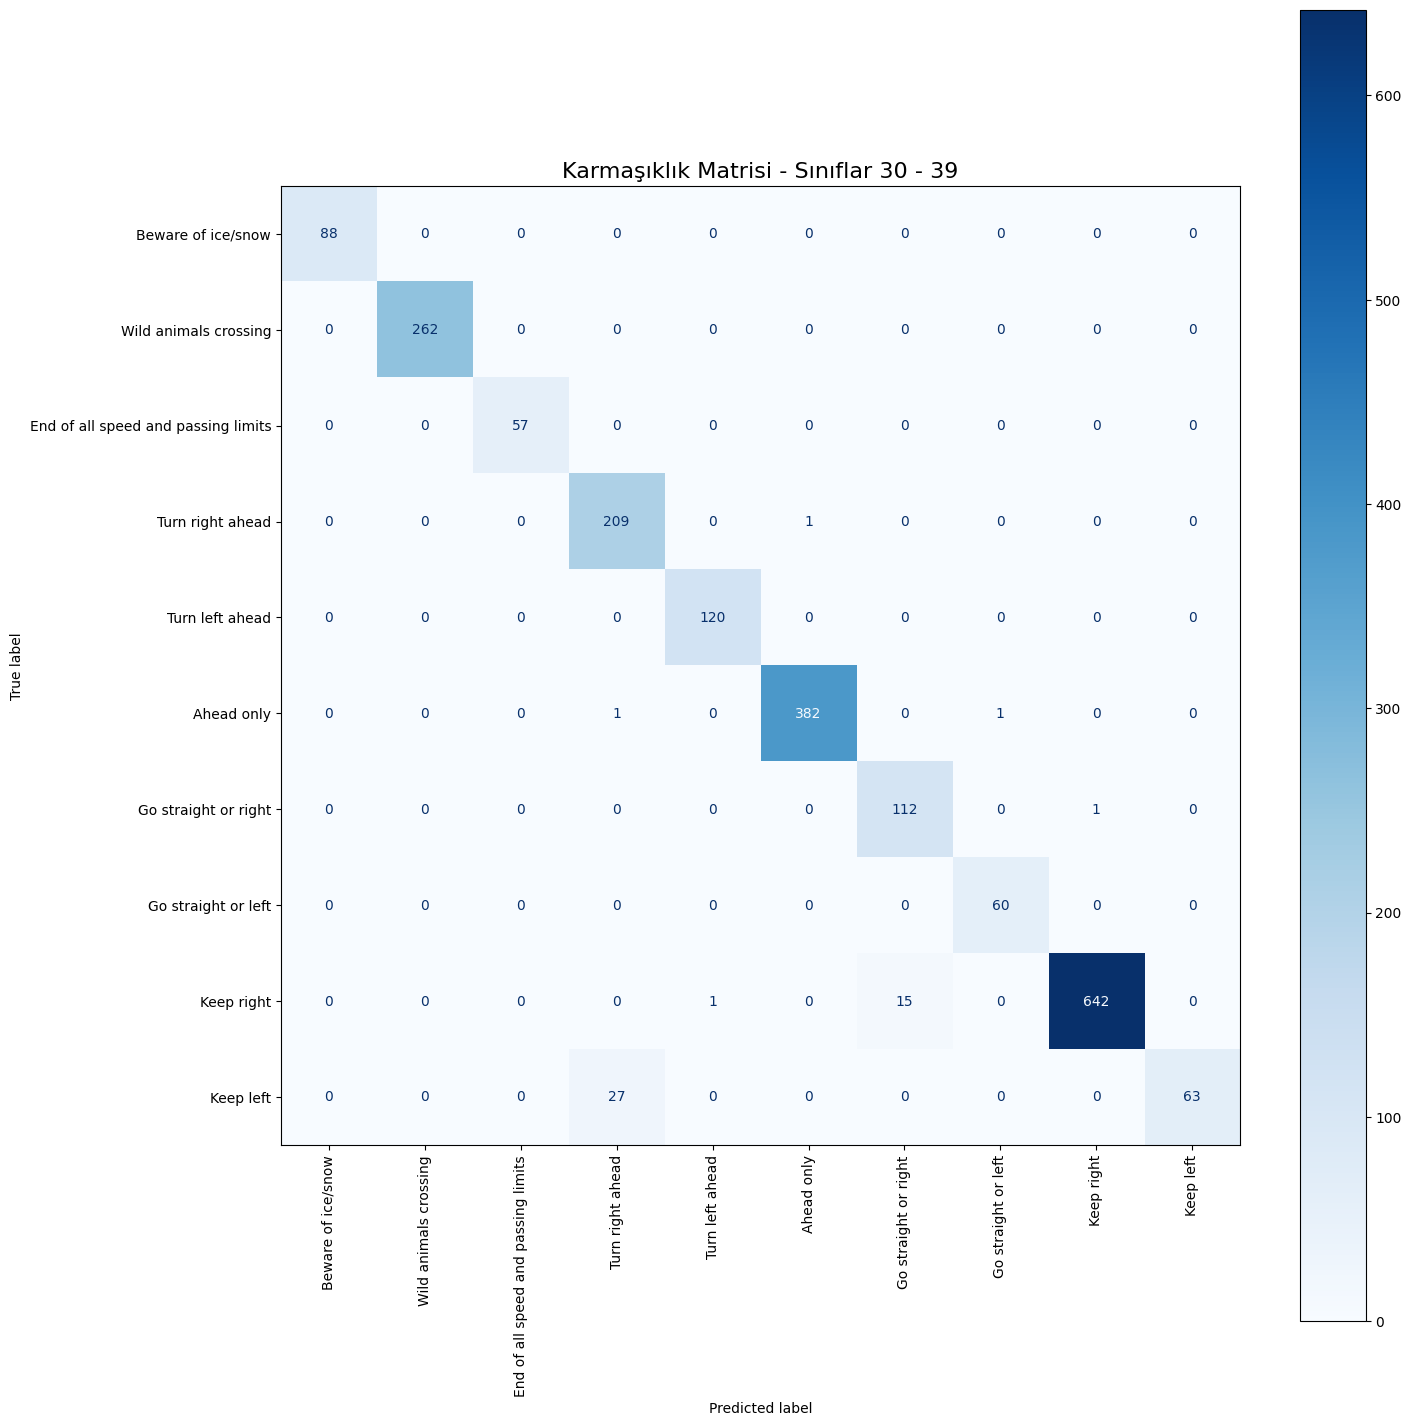

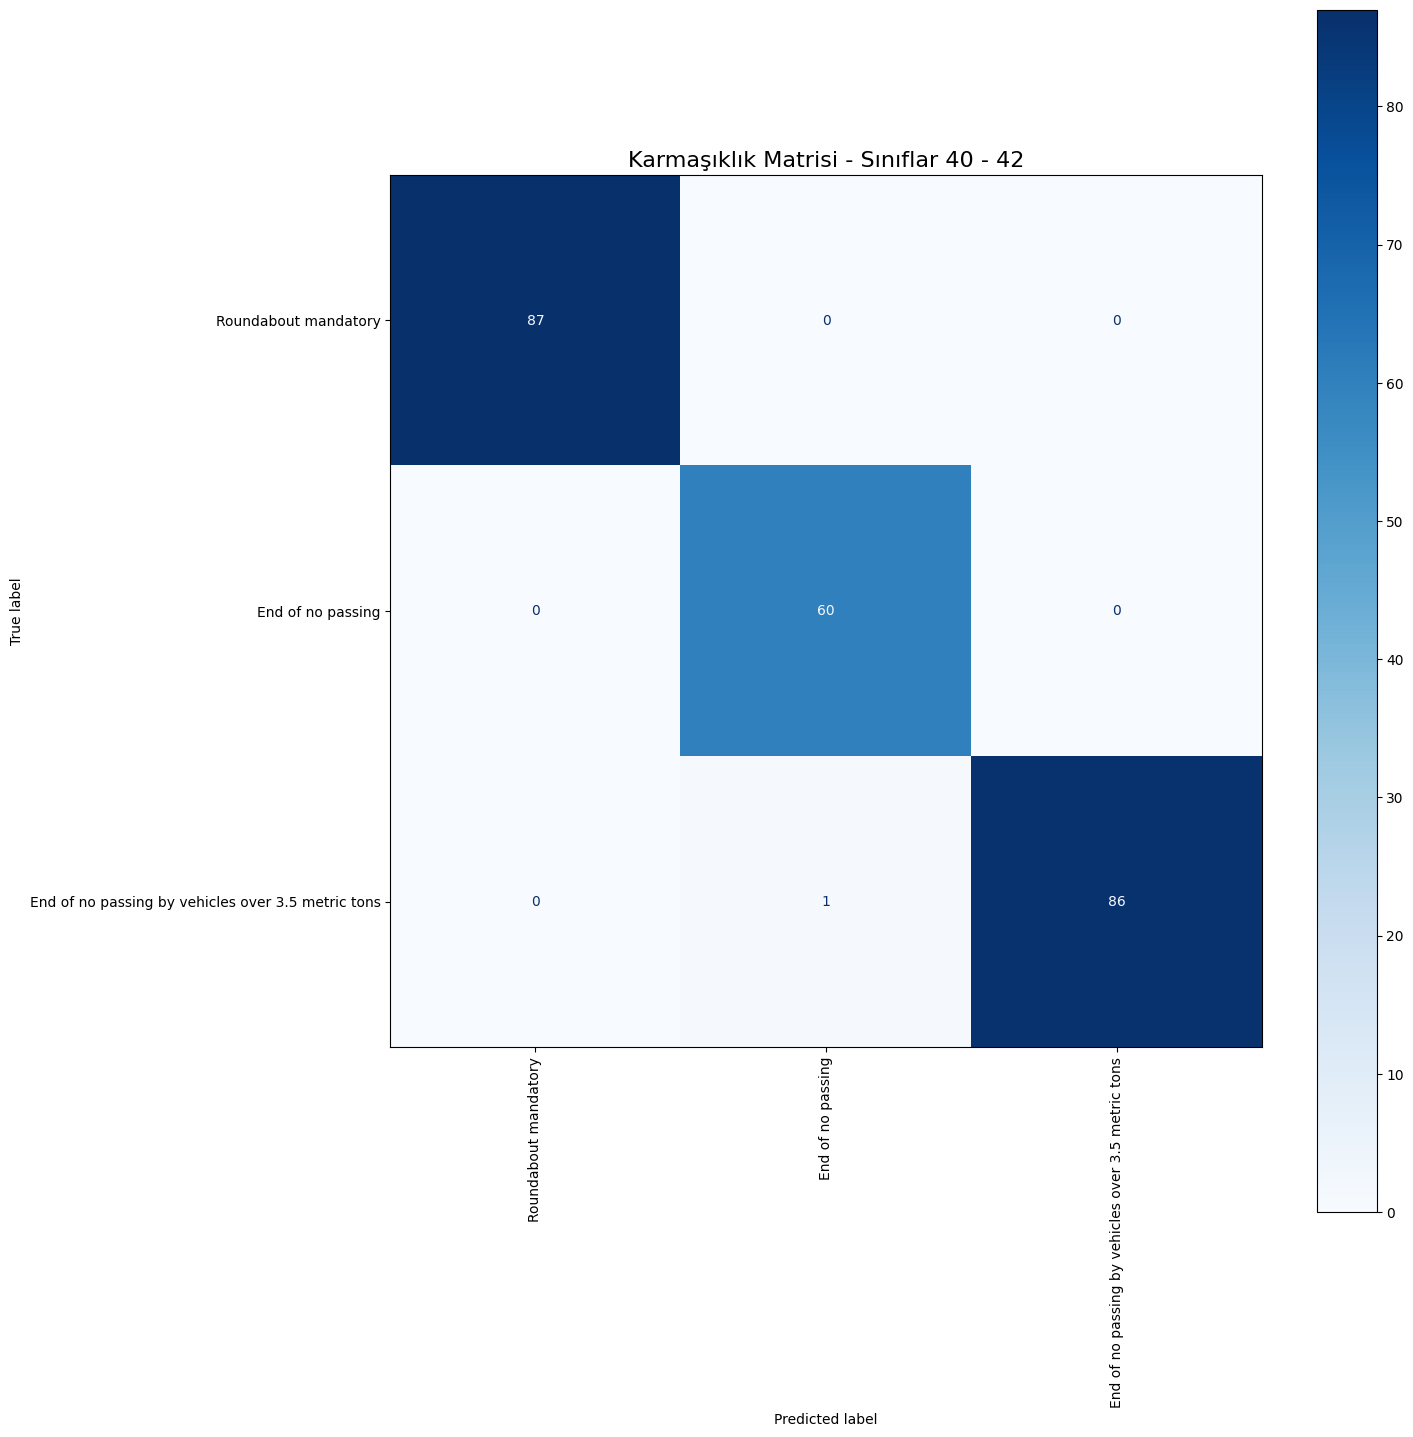

In [13]:
data_path = "/kaggle/input/traffic-signs-preprocessed/"
labels_df = pd.read_csv(os.path.join(data_path, 'label_names.csv'))
sign_names = labels_df['SignName'].tolist()

# Tahminleri ve gerçek etiketlerin hazırlanması
y_pred = optimized_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

# Sınıfların daha küçük gruplara ayıralması
num_classes = len(sign_names)
group_size = 10 
num_groups = int(np.ceil(num_classes / group_size))

for i in range(num_groups):
    start_class = i * group_size
    end_class = min((i + 1) * group_size, num_classes)
    
    # Sadece ilgili sınıfların filtrelenmesi
    class_indices = list(range(start_class, end_class))
    
    # Gerçek ve tahmin edilen etiketlerin bu sınıflara göre filtrelenmesi
    filtered_indices = [idx for idx, true_label in enumerate(y_true) if true_label in class_indices]
    
    if not filtered_indices:
        continue

    y_true_filtered = np.array(y_true)[filtered_indices]
    y_pred_filtered = y_pred_classes[filtered_indices]
    
    # Karmaşılık Matrisi'nin oluşturulması
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=class_indices)
    
    # Etiket isimlerinin filtrelenmesi
    display_labels = [sign_names[j] for j in class_indices]

    # Grafiğin çizilmesi
    fig, ax = plt.subplots(figsize=(15, 15))
    disp = ConfusionMatrixDisplay(cm, display_labels=display_labels)
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=90)
    
    plt.title(f"Karmaşıklık Matrisi - Sınıflar {start_class} - {end_class-1}", fontsize=16)
    plt.tight_layout()
    plt.show()

# 🔍 Grad-CAM: Görsel Açıklanabilirlik için Neden Kullanırız?

## 🎯 Grad-CAM'in Temel Amacı

**Grad-CAM (Gradient-weighted Class Activation Mapping)**, derin öğrenme modellerinin karar verme süreçlerini görselleştirmek ve anlamak için kullanılan güçlü bir tekniktir. "Kara kutu" olarak nitelendirilen derin sinir ağlarının iç işleyişini şeffaf hale getirir.

---

## ❌ Grad-CAM Olmadan Ne Kaybederiz?

### **Kara Kutu Problemi:**
```python
# Model tahmini - sadece sonuç görüyoruz
prediction = model.predict(image)
# Çıktı: "Bu görüntü %92 olasılıkla 'Dur' işareti"
# AMA: Model bu kararı nasıl verdi? Hangi piksellere baktı?

In [14]:
def compare_predictions_vs_actual(model, X_test, y_test, num_samples=15):
    """
    Tahmin edilen ve gerçek değerleri karşılaştırarak görselleştirir
    """
    # Tahminlerin alınması
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = y_test
    
    # Rastgele örneklerin seçilmesi
    indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)
    
    # Grid boyutunun hesaplanması
    cols = 5
    rows = (num_samples + cols - 1) // cols
    
    plt.figure(figsize=(20, 4 * rows))
    plt.suptitle('🔍 TAHMİN vs GERÇEK KARŞILAŞTIRMASI', fontsize=20, y=1.02)
    
    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_label = y_true[idx]
        pred_label = y_pred_classes[idx]
        confidence = y_pred[idx][pred_label]
        
        true_class = sign_names[true_label]
        pred_class = sign_names[pred_label]
        
        # Tahminin doğru olup olmadığının kontrol edilmesi
        is_correct = (true_label == pred_label)
        color = 'green' if is_correct else 'red'
        result_text = '✅ DOĞRU' if is_correct else '❌ YANLIŞ'
        
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f'{result_text}\nGerçek: {true_class}\nTahmin: {pred_class}\nGüven: {confidence:.3f}', 
                 color=color, fontsize=10)
        plt.axis('off')
        
        # Resmin etrafına renkli kenarlık eklenmesi
        border_color = 'limegreen' if is_correct else 'red'
        for spine in plt.gca().spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)
    
    plt.tight_layout()
    plt.show()
    
    # İstatistiklerin gösterilmesi
    print_statistics(y_true, y_pred_classes)

def print_statistics(y_true, y_pred_classes):
    """İstatistiksel bilgileri yazdır"""
    accuracy = np.mean(y_true == y_pred_classes)
    
    print("📊 DETAYLI TAHMİN İSTATİSTİKLERİ")
    print("=" * 50)
    print(f"Toplam Test Örnek Sayısı: {len(y_true)}")
    print(f"Doğru Tahmin Sayısı: {np.sum(y_true == y_pred_classes)}")
    print(f"Yanlış Tahmin Sayısı: {np.sum(y_true != y_pred_classes)}")
    print(f"Genel Doğruluk: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Sınıf bazında accuracy
    print(f"\n🎯 SINIF BAZINDA DOĞRULUK:")
    unique_classes = np.unique(y_true)
    for cls in unique_classes:
        cls_indices = y_true == cls
        if np.sum(cls_indices) > 0:
            cls_accuracy = np.mean(y_pred_classes[cls_indices] == cls)
            print(f"Sınıf {cls:2d} ({sign_names[cls]:20s}): {cls_accuracy:.3f}")

def show_detailed_comparison(model, X_test, y_test, specific_indices=None):
    """
    Belirli örnekler için detaylı karşılaştırma
    """
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    if specific_indices is None:
        # Yanlış tahminlerden örneklerin gösterilmesi
        wrong_indices = np.where(y_test != y_pred_classes)[0]
        if len(wrong_indices) > 0:
            specific_indices = wrong_indices[:5]  # İlk 5 yanlış tahmin
        else:
            print("🎉 Hiç yanlış tahmin yok!")
            return
    
    print(f"🔍 DETAYLI KARŞILAŞTIRMA ({len(specific_indices)} örnek)")
    
    for i, idx in enumerate(specific_indices):
        img = X_test[idx]
        true_label = y_test[idx]
        pred_label = y_pred_classes[idx]
        confidence = y_pred[idx][pred_label]
        
        true_class = sign_names[true_label]
        pred_class = sign_names[pred_label]
        is_correct = (true_label == pred_label)
        
        # Tüm sınıf olasılıklarının alınması (en yüksek 5)
        top5_indices = np.argsort(y_pred[idx])[-5:][::-1]
        top5_classes = [sign_names[i] for i in top5_indices]
        top5_probs = y_pred[idx][top5_indices]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Görsel
        ax1.imshow(img)
        ax1.set_title(f'Örnek {idx} - {"✅ DOĞRU" if is_correct else "❌ YANLIŞ"}', 
                     color='green' if is_correct else 'red', fontsize=14)
        ax1.text(0.5, -0.15, f'Gerçek: {true_class}\nTahmin: {pred_class}\nGüven: {confidence:.3f}', 
                transform=ax1.transAxes, ha='center', fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        ax1.axis('off')
        
        # Olasılık dağılımı
        y_pos = np.arange(len(top5_classes))
        colors = ['green' if i == true_label else 'red' if i == pred_label else 'gray' 
                 for i in top5_indices]
        
        bars = ax2.barh(y_pos, top5_probs, color=colors, alpha=0.7)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(top5_classes)
        ax2.set_xlabel('Olasılık')
        ax2.set_title('En Yüksek 5 Sınıf Olasılığı')
        ax2.set_xlim(0, 1)
        
        # Değerlerin çubukların üzerine yazılması
        for bar, prob in zip(bars, top5_probs):
            width = bar.get_width()
            ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{prob:.3f}', ha='left', va='center')
        
        plt.tight_layout()
        plt.show()

def create_prediction_analysis_report(model, X_test, y_test):
    """
    Kapsamlı tahmin analiz raporu oluşturur
    """
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = y_test
    
    # Accuracy hesaplama
    accuracy = np.mean(y_true == y_pred_classes)
    
    # Karmaşıklık matrisi
    cm = confusion_matrix(y_true, y_pred_classes)
    
    print("📈 KAPSAMLI TAHMİN ANALİZ RAPORU")
    print("=" * 60)
    
    # Genel istatistikler
    print(f"\n📊 GENEL İSTATİSTİKLER:")
    print(f"   • Toplam Örnek: {len(y_true)}")
    print(f"   • Doğru Tahmin: {np.sum(y_true == y_pred_classes)}")
    print(f"   • Yanlış Tahmin: {np.sum(y_true != y_pred_classes)}")
    print(f"   • Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # En sık yapılan hatalar
    wrong_indices = np.where(y_true != y_pred_classes)[0]
    if len(wrong_indices) > 0:
        print(f"\n❌ EN SIK HATALAR (ilk 5):")
        error_pairs = []
        for idx in wrong_indices[:5]:
            true_cls = sign_names[y_true[idx]]
            pred_cls = sign_names[y_pred_classes[idx]]
            confidence = y_pred[idx][y_pred_classes[idx]]
            error_pairs.append((true_cls, pred_cls, confidence))
        
        for i, (true, pred, conf) in enumerate(error_pairs):
            print(f"   {i+1}. {true} → {pred} (güven: {conf:.3f})")
    
    # En güvenilen tahminler
    confidences = y_pred[np.arange(len(y_pred)), y_pred_classes]
    top_conf_indices = np.argsort(confidences)[-5:][::-1]
    
    print(f"\n💪 EN GÜVENİLEN TAHMİNLER (ilk 5):")
    for i, idx in enumerate(top_conf_indices):
        true_cls = sign_names[y_true[idx]]
        pred_cls = sign_names[y_pred_classes[idx]]
        conf = confidences[idx]
        status = "✅" if y_true[idx] == y_pred_classes[idx] else "❌"
        print(f"   {i+1}. {status} {true_cls} → {pred_cls} (güven: {conf:.3f})")



1. TEMEL TAHMİN-GERÇEK KARŞILAŞTIRMASI


/tmp/ipykernel_19/648935263.py:46: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/648935263.py:46: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/648935263.py:46: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


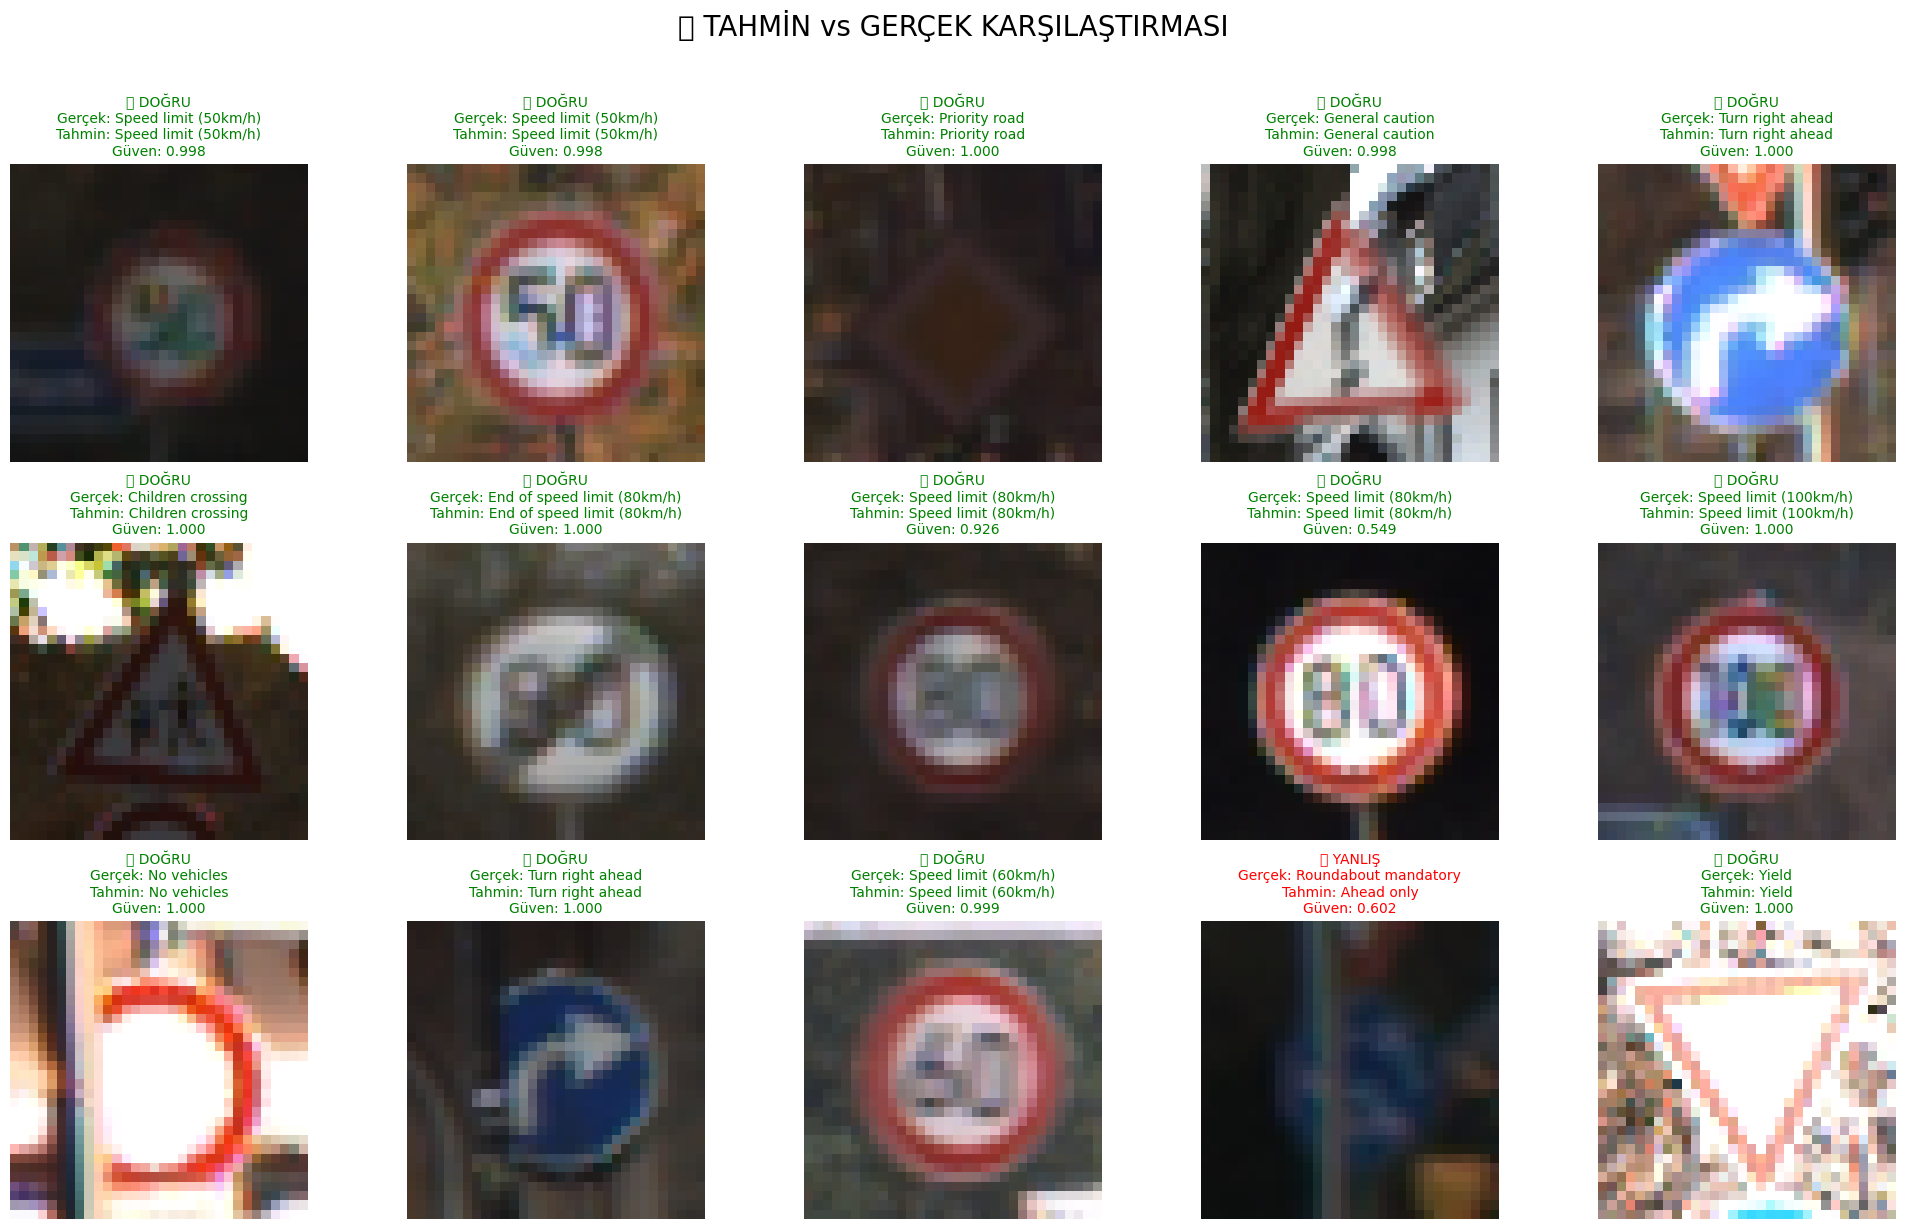

📊 DETAYLI TAHMİN İSTATİSTİKLERİ
Toplam Test Örnek Sayısı: 12630
Doğru Tahmin Sayısı: 11756
Yanlış Tahmin Sayısı: 874
Genel Doğruluk: 0.9308 (93.08%)

🎯 SINIF BAZINDA DOĞRULUK:
Sınıf  0 (Speed limit (20km/h)): 0.983
Sınıf  1 (Speed limit (30km/h)): 0.988
Sınıf  2 (Speed limit (50km/h)): 0.925
Sınıf  3 (Speed limit (60km/h)): 0.924
Sınıf  4 (Speed limit (70km/h)): 0.955
Sınıf  5 (Speed limit (80km/h)): 0.775
Sınıf  6 (End of speed limit (80km/h)): 0.900
Sınıf  7 (Speed limit (100km/h)): 0.838
Sınıf  8 (Speed limit (120km/h)): 0.980
Sınıf  9 (No passing          ): 0.998
Sınıf 10 (No passing for vehicles over 3.5 metric tons): 0.956
Sınıf 11 (Right-of-way at the next intersection): 0.902
Sınıf 12 (Priority road       ): 0.893
Sınıf 13 (Yield               ): 0.997
Sınıf 14 (Stop                ): 1.000
Sınıf 15 (No vehicles         ): 1.000
Sınıf 16 (Vehicles over 3.5 metric tons prohibited): 1.000
Sınıf 17 (No entry            ): 0.914
Sınıf 18 (General caution     ): 0.851
Sınıf 19 (Dan

/tmp/ipykernel_19/648935263.py:134: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()


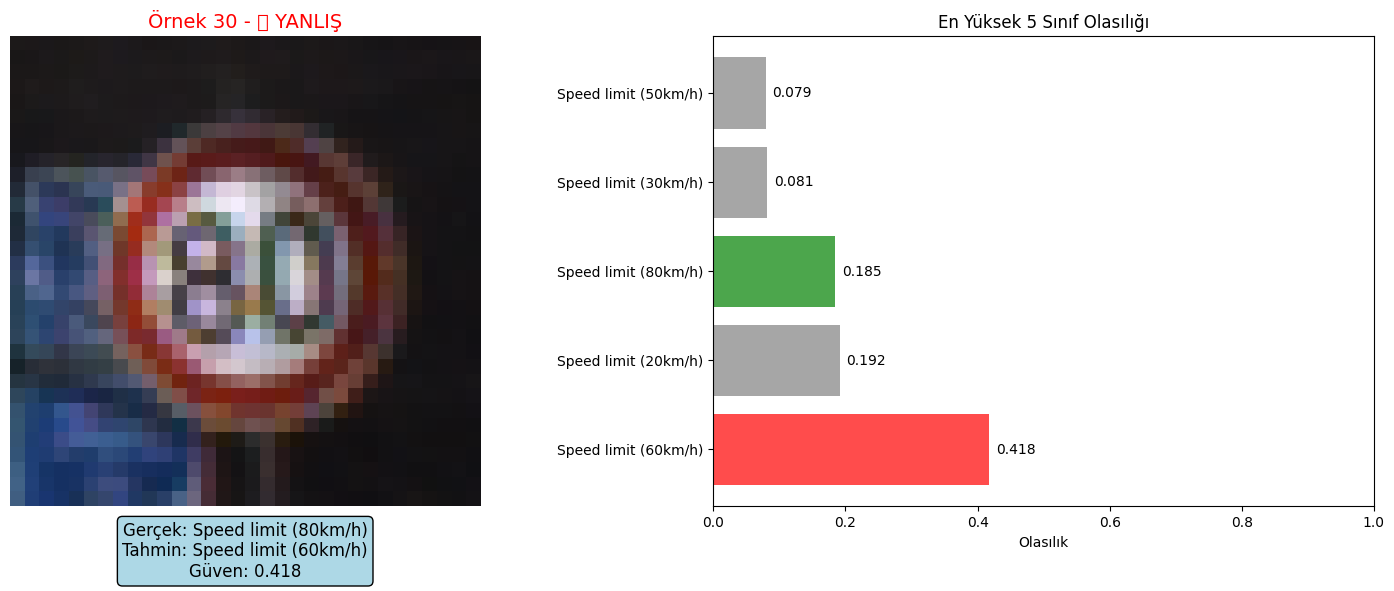

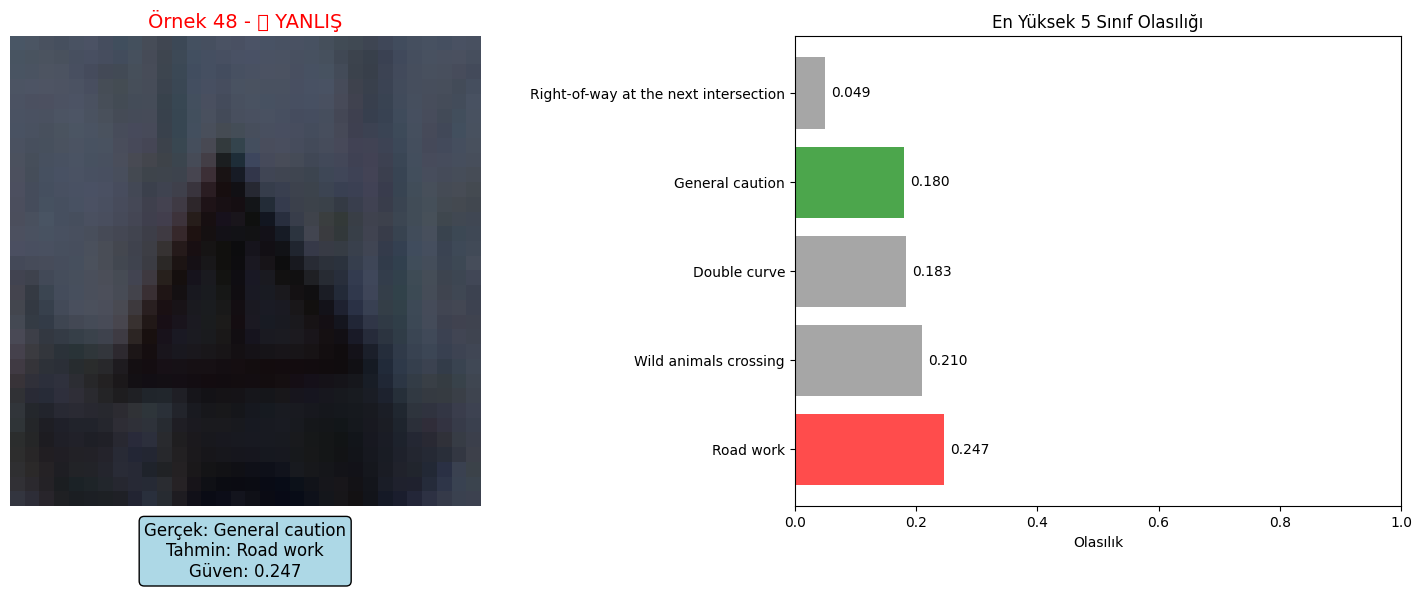

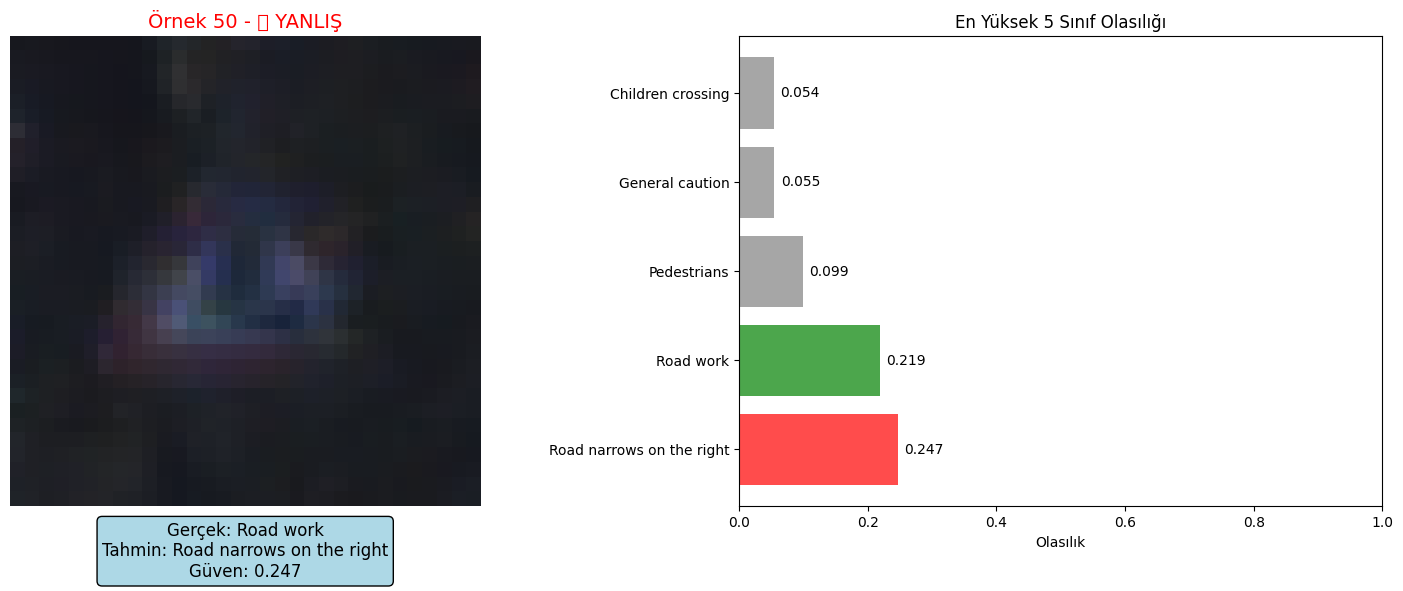

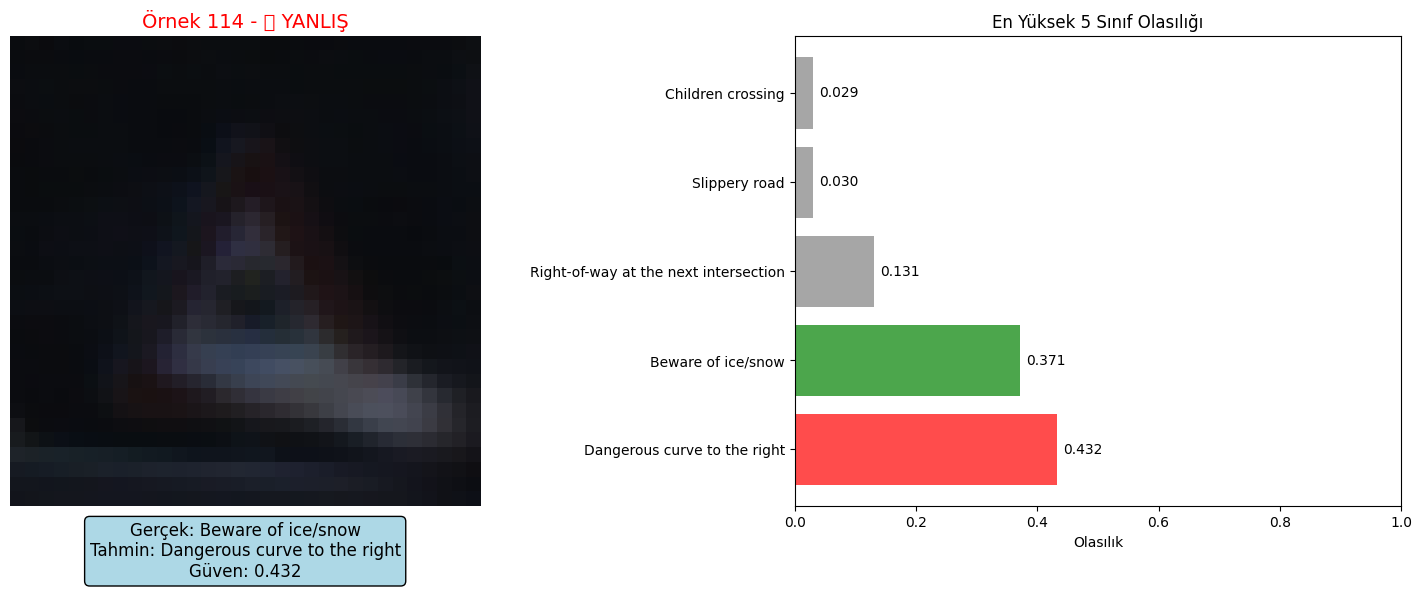

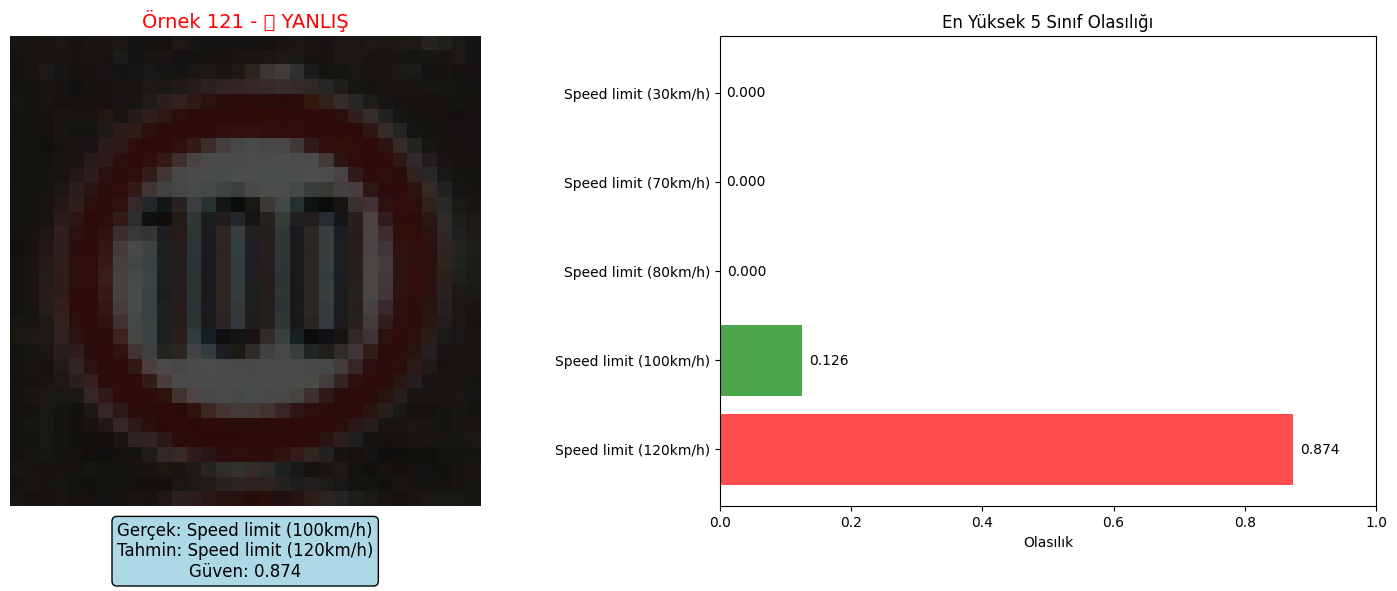


3. ÖZEL ÖRNEKLER İÇİN ANALİZ
🔍 DETAYLI KARŞILAŞTIRMA (5 örnek)


/tmp/ipykernel_19/648935263.py:134: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()


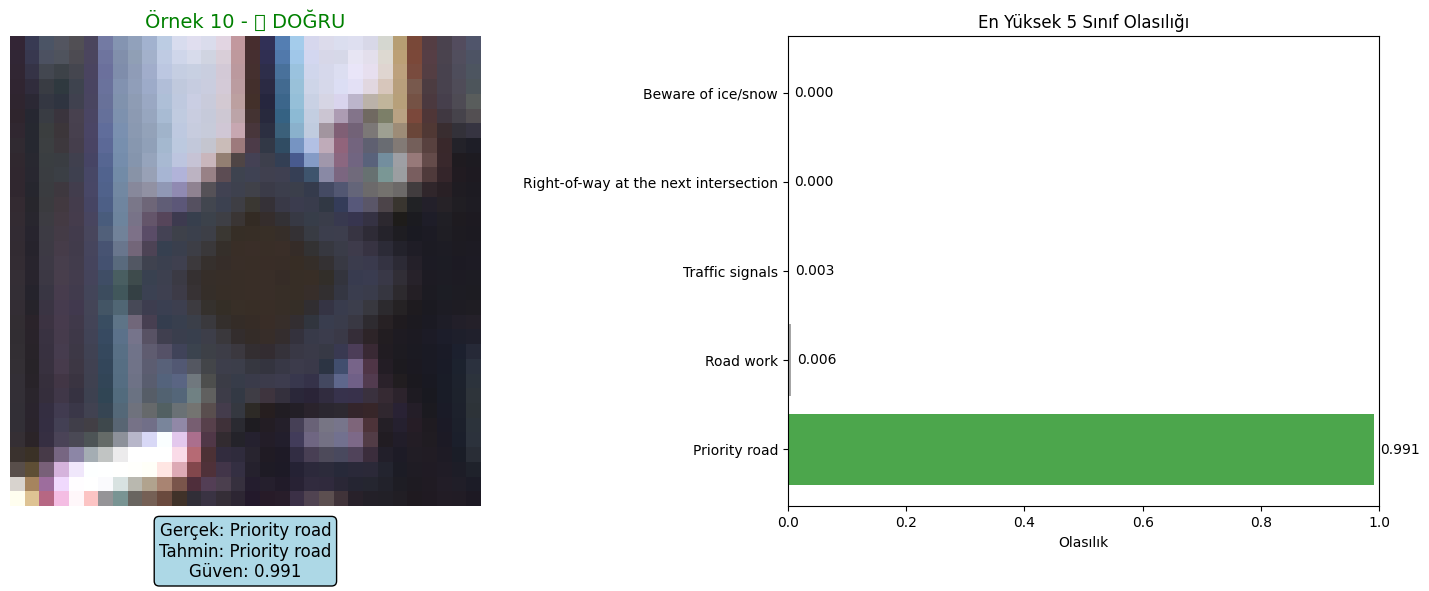

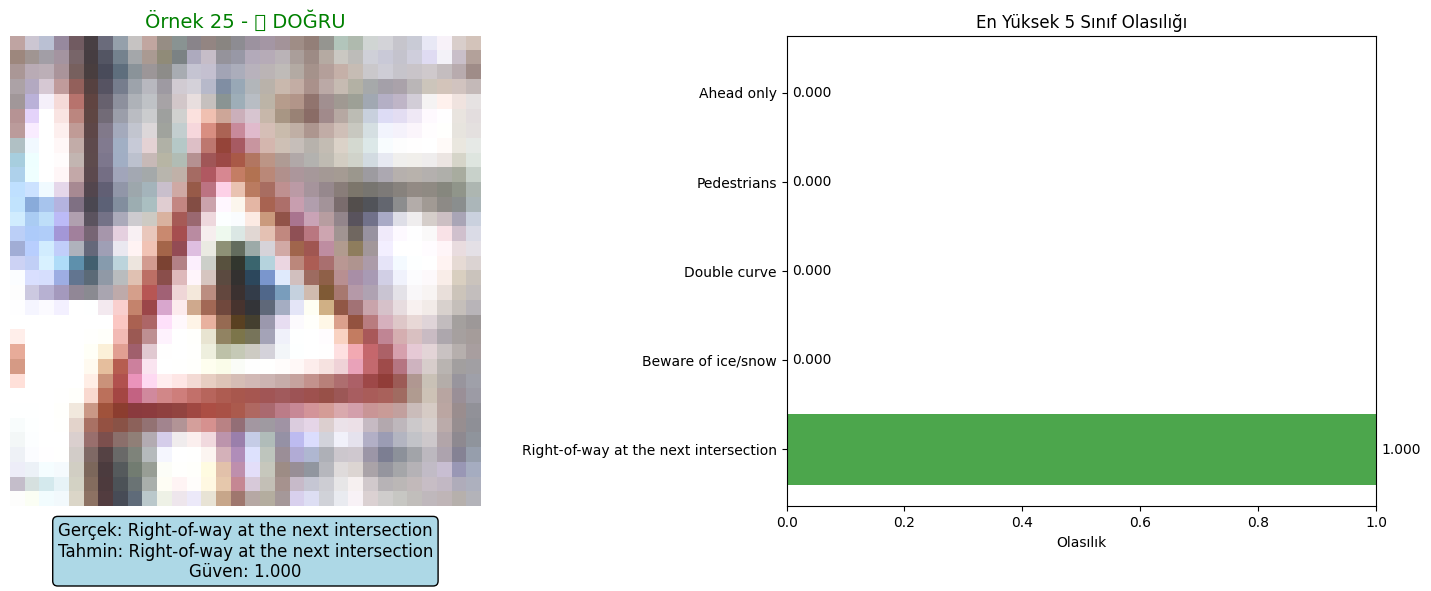

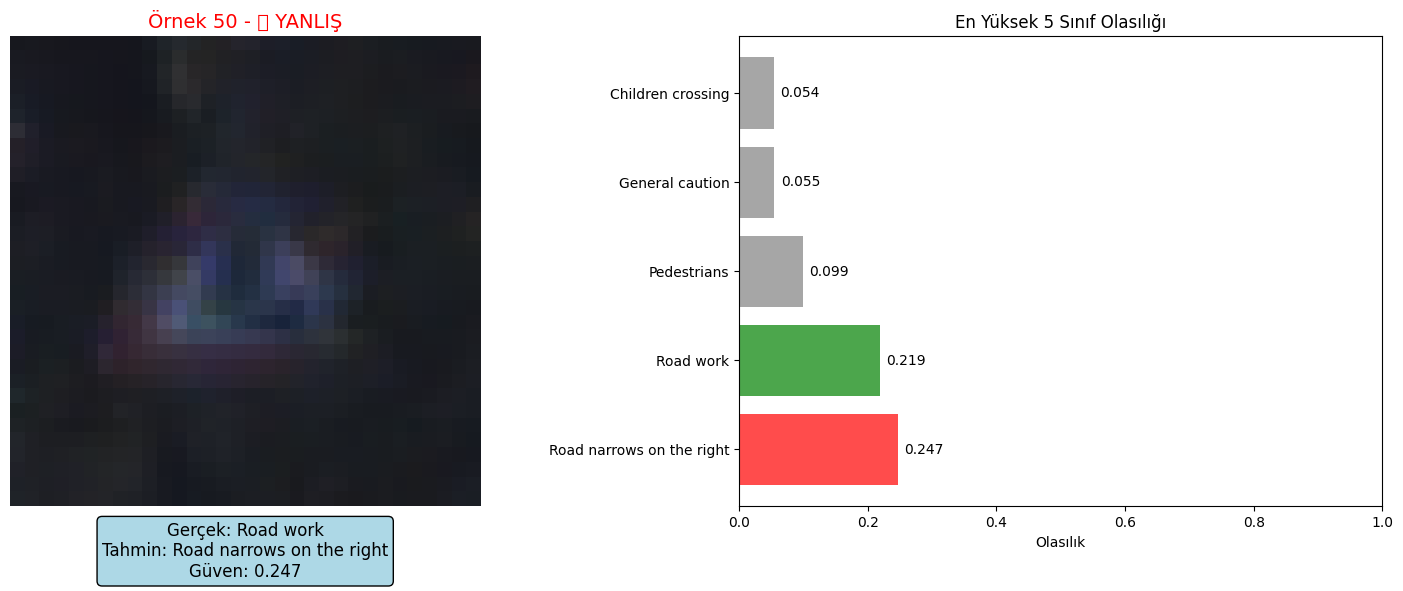

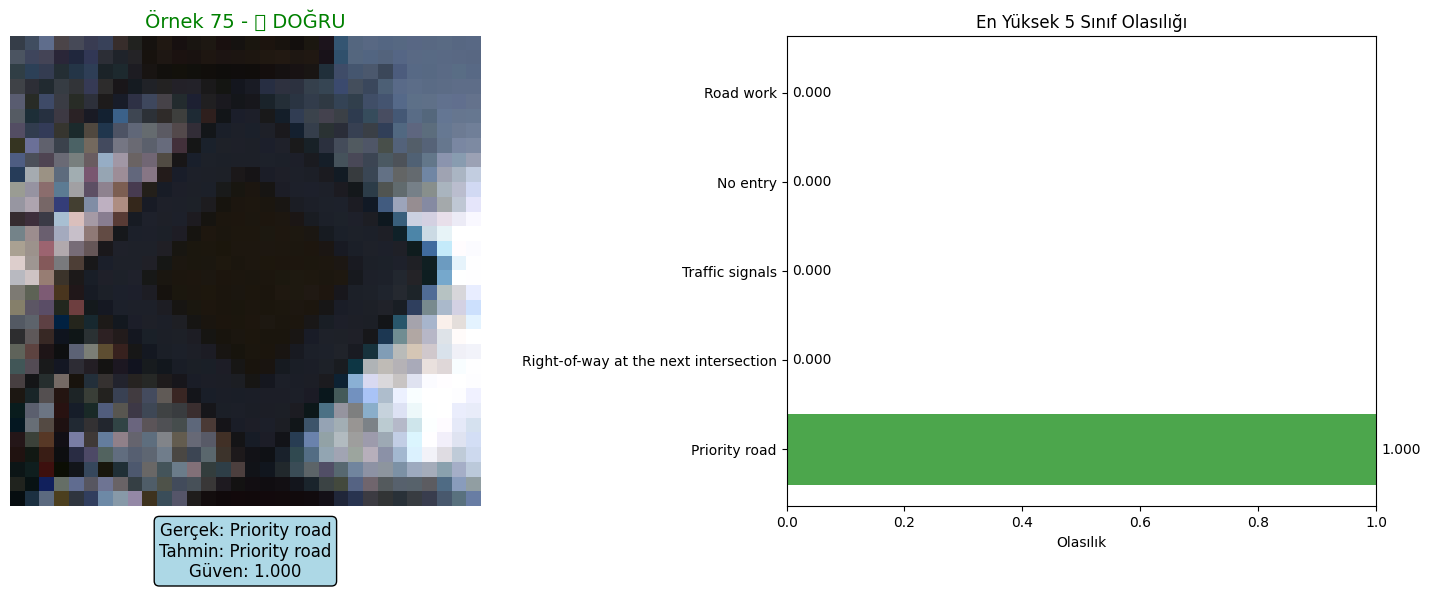

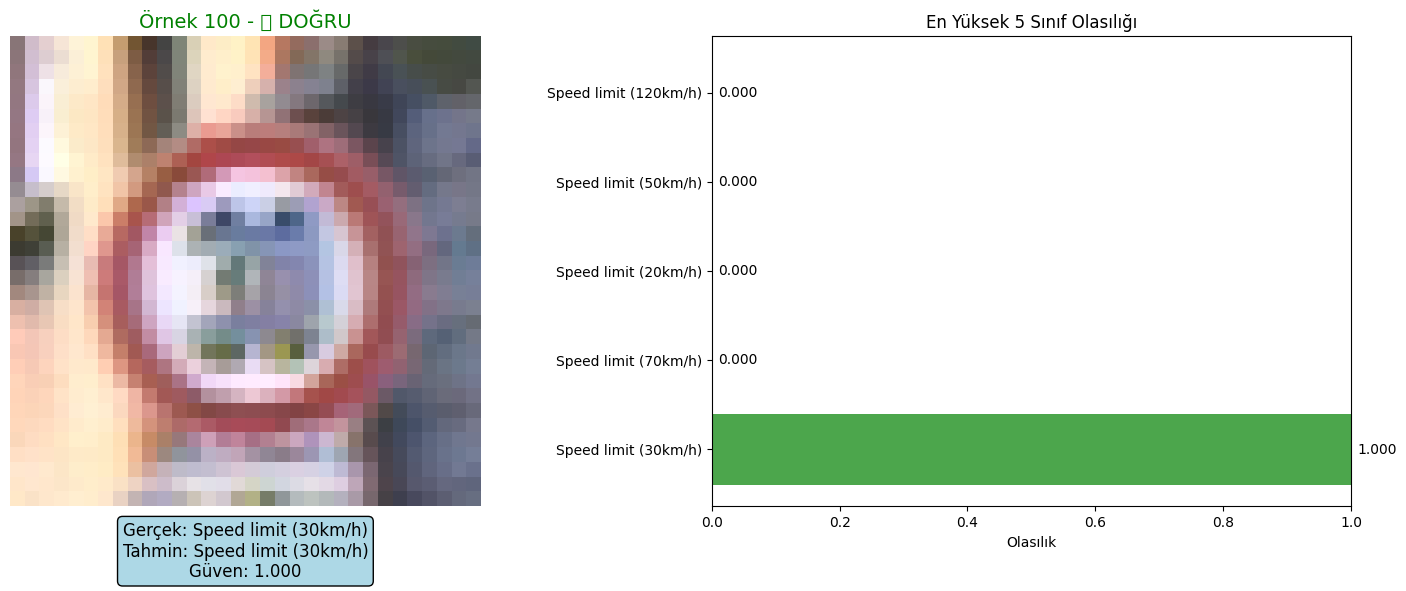


4. KAPSAMLI TAHMİN ANALİZ RAPORU
📈 KAPSAMLI TAHMİN ANALİZ RAPORU

📊 GENEL İSTATİSTİKLER:
   • Toplam Örnek: 12630
   • Doğru Tahmin: 11756
   • Yanlış Tahmin: 874
   • Accuracy: 0.9308 (93.08%)

❌ EN SIK HATALAR (ilk 5):
   1. Speed limit (80km/h) → Speed limit (60km/h) (güven: 0.418)
   2. General caution → Road work (güven: 0.247)
   3. Road work → Road narrows on the right (güven: 0.247)
   4. Beware of ice/snow → Dangerous curve to the right (güven: 0.432)
   5. Speed limit (100km/h) → Speed limit (120km/h) (güven: 0.874)

💪 EN GÜVENİLEN TAHMİNLER (ilk 5):
   1. ✅ No passing for vehicles over 3.5 metric tons → No passing for vehicles over 3.5 metric tons (güven: 1.000)
   2. ✅ Yield → Yield (güven: 1.000)
   3. ✅ Road work → Road work (güven: 1.000)
   4. ✅ Priority road → Priority road (güven: 1.000)
   5. ✅ Road work → Road work (güven: 1.000)


In [15]:
# Temel Karşılaştırma
print("1. TEMEL TAHMİN-GERÇEK KARŞILAŞTIRMASI")
compare_predictions_vs_actual(optimized_model, X_test, y_test, num_samples=15)

# Detaylı analiz (yanlış tahminlere odaklanılır)
print("\n2. DETAYLI YANLIŞ TAHMİN ANALİZİ")
show_detailed_comparison(optimized_model, X_test, y_test)

# Özel örnekler için analiz
print("\n3. ÖZEL ÖRNEKLER İÇİN ANALİZ")
specific_indices = [10, 25, 50, 75, 100]  # İstediğiniz indeksleri verebilirsiniz
show_detailed_comparison(optimized_model, X_test, y_test, specific_indices)

# 4. Kapsamlı rapor
print("\n4. KAPSAMLI TAHMİN ANALİZ RAPORU")
create_prediction_analysis_report(optimized_model, X_test, y_test)

## 📌 Transfer Learning (Aktarım Öğrenmesi)

Transfer Learning, önceden büyük veri kümeleri (örneğin **ImageNet**) üzerinde eğitilmiş derin öğrenme modellerinin,
yeni bir problemde tekrar kullanılmasını sağlayan bir yöntemdir. 

Böylece sıfırdan model eğitmek yerine, daha önce öğrenilmiş **özellik çıkarıcıları (feature extractor)** kullanılır
ve sadece son katman(lar) yeni problem için yeniden eğitilir. 

### Avantajları
- 🚀 **Daha hızlı eğitim:** Modelin büyük kısmı zaten eğitildiği için daha az epoch ile yüksek doğruluk elde edilebilir.  
- 📉 **Az veri ile çalışabilme:** Küçük veri setlerinde sıfırdan CNN eğitmek zor olur, Transfer Learning bu sorunu çözer.  
- 🎯 **Yüksek performans:** Özellikle görsel tanıma görevlerinde daha yüksek doğruluk sağlar.  

### Çalışma Prensibi
1. **Pretrained Model (örn. VGG16, ResNet, MobileNet)**, ImageNet gibi büyük bir veri kümesinde eğitilir.  
2. Bu modelin **erken katmanları (low-level features: kenarlar, dokular)** korunur.  
3. Çıkış kısmındaki **classification head (tam bağlantılı katmanlar)** silinir.  
4. Yeni veri kümesine uygun bir **Dense + Softmax** katmanı eklenir.  
5. İlk etapta **base model dondurulur** (ağırlıklar değişmez), sadece yeni eklenen katmanlar eğitilir.  
6. Gerekirse daha sonra **fine-tuning** yapılır, yani bazı üst katmanlar açılır ve küçük bir learning rate ile yeniden eğitilir.  

🔑 Özetle: **Transfer Learning**, önceden öğrenilmiş bilgiyi yeniden kullanarak hem zamanı kısaltır hem de doğruluğu artırır.


In [16]:
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train.shape[1:])
base_model.trainable = False  # ilk etapta donduruyoruz

tl_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(len(sign_names), activation="softmax")
])

tl_model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

history_tl = tl_model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=15,
    batch_size=32,
    verbose=1
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.1374 - loss: 3.3101 - val_accuracy: 0.3387 - val_loss: 2.4269
Epoch 2/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3366 - loss: 2.3515 - val_accuracy: 0.3802 - val_loss: 2.1416
Epoch 3/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3998 - loss: 2.0535 - val_accuracy: 0.4088 - val_loss: 1.9921
Epoch 4/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4474 - loss: 1.8694 - val_accuracy: 0.4259 - val_loss: 1.9035
Epoch 5/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4777 - loss: 1.7470 - val_accuracy: 0.4396 - val_loss: 1.8382
Epoch 6/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5061 - loss: 1.6362 - val_accuracy: 0.4482 - val_loss: 1.7909
Epoch 7/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5255 - loss: 1.5711 - val_accuracy: 0.4530 - val_loss: 1.7550
Epoch 8/15
1088/1088 ━━━━━━━━━━━━━━━━

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

=== CNN Model ===
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.69      0.98      0.81        60
                              Speed limit (30km/h)       0.90      0.99      0.94       720
                              Speed limit (50km/h)       0.93      0.93      0.93       750
                              Speed limit (60km/h)       0.92      0.92      0.92       450
                              Speed limit (70km/h)       0.99      0.95      0.97       660
                              Speed limit (80km/h)       0.88      0.77      0.82       630
                       End of speed limit (80km/h)       0.99      0.90      0.94       150
                             Speed limit (100km/h)       0.95      0.84      0.89       450
                             Speed limit (120km/h)       0.89      0.98      0.93       450
                   

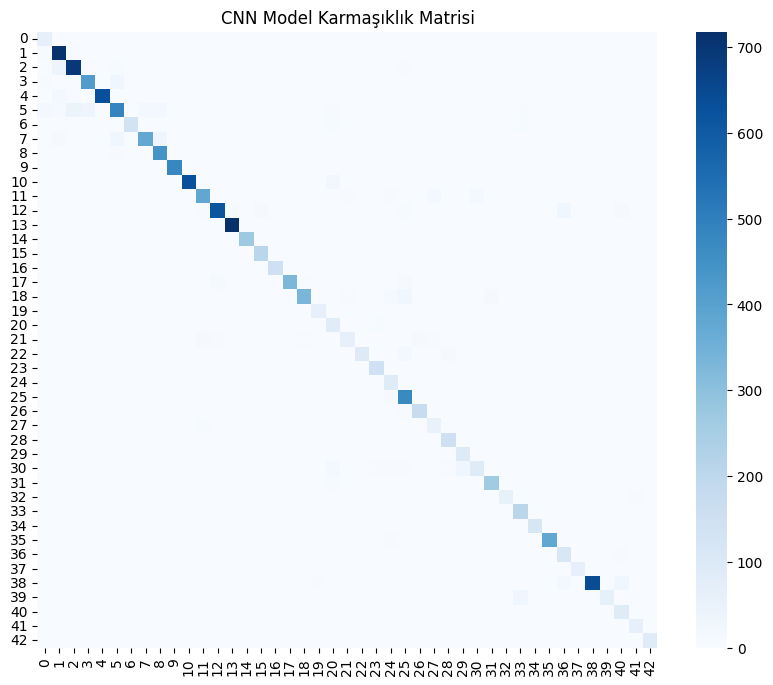

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

=== Transfer Learning (VGG16) ===
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.00      0.00      0.00        60
                              Speed limit (30km/h)       0.48      0.64      0.55       720
                              Speed limit (50km/h)       0.38      0.27      0.32       750
                              Speed limit (60km/h)       0.17      0.17      0.17       450
                              Speed limit (70km/h)       0.26      0.41      0.32       660
                              Speed limit (80km/h)       0.28      0.26      0.27       630
                       End of speed limit (80km/h)       0.74      0.60      0.66       150
                             Speed limit (100km/h)       0.40      0.32      0.36       450
                             Speed limit (120km/h)       0.18      0.10      0.13       450
   

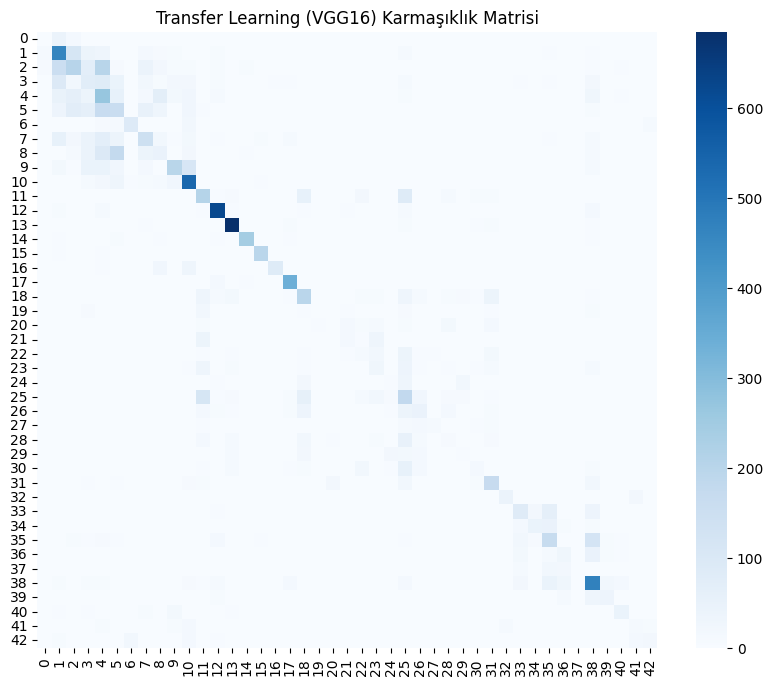

In [17]:
# Test değerlendirme
def evaluate_and_report(model, X_test, y_test, model_name):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(f"\n=== {model_name} ===")
    print(classification_report(y_test, y_pred, target_names=sign_names))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(f"{model_name} Karmaşıklık Matrisi")
    plt.show()

evaluate_and_report(optimized_model, X_test, y_test, "CNN Model")
evaluate_and_report(tl_model, X_test, y_test, "Transfer Learning (VGG16)")

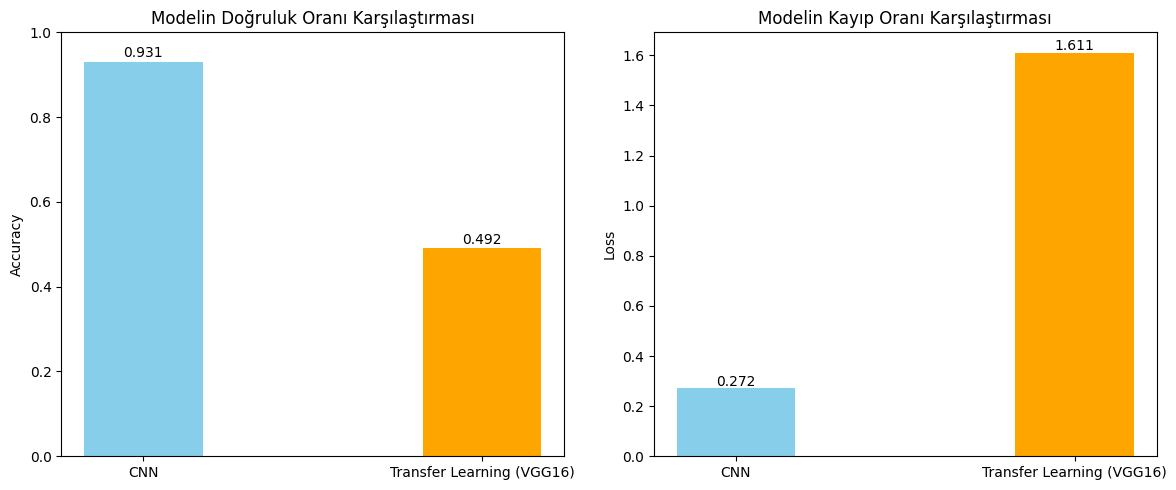

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Modellerin değerlendirilmesi
cnn_loss, cnn_acc = optimized_model.evaluate(X_test, y_test_cat, verbose=0)
tl_loss, tl_acc   = tl_model.evaluate(X_test, y_test_cat, verbose=0)

# Karşılaştırma için veri
models = ["CNN", "Transfer Learning (VGG16)"]
accuracy = [cnn_acc, tl_acc]
losses   = [cnn_loss, tl_loss]

x = np.arange(len(models))
width = 0.35  # çubuk genişliği

# Accuracy grafiği
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.bar(x, accuracy, width, color=["skyblue", "orange"])
plt.xticks(x, models)
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Modelin Doğruluk Oranı Karşılaştırması")
for i, v in enumerate(accuracy):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')

# Loss grafiği
plt.subplot(1,2,2)
plt.bar(x, losses, width, color=["skyblue", "orange"])
plt.xticks(x, models)
plt.ylabel("Loss")
plt.title("Modelin Kayıp Oranı Karşılaştırması")
for i, v in enumerate(losses):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()


In [19]:
def compare_models(cnn_acc, cnn_loss, tl_acc, tl_loss):
    print("📊 Model Karşılaştırma Sonuçları")
    print("-" * 40)
    
    # Accuracy karşılaştırma
    if tl_acc > cnn_acc:
        print(f"✅ Transfer Learning daha yüksek doğruluk sağladı ({tl_acc:.2f} vs {cnn_acc:.2f})")
    elif cnn_acc > tl_acc:
        print(f"✅ CNN daha yüksek doğruluk sağladı ({cnn_acc:.2f} vs {tl_acc:.2f})")
    else:
        print(f"⚖️ Her iki modelin doğruluğu aynı: {cnn_acc:.2f}")
    
    # Loss karşılaştırma
    if tl_loss < cnn_loss:
        print(f"✅ Transfer Learning daha düşük hata oranına sahip ({tl_loss:.2f} vs {cnn_loss:.2f})")
    elif cnn_loss < tl_loss:
        print(f"✅ CNN daha düşük hata oranına sahip ({cnn_loss:.2f} vs {tl_loss:.2f})")
    else:
        print(f"⚖️ Her iki modelin hata oranı aynı: {cnn_loss:.2f}")
    
    # Genel yorum
    if (tl_acc > cnn_acc) and (tl_loss < cnn_loss):
        print("\n🌟 Genel Sonuç: Transfer Learning modeli açıkça daha başarılı görünüyor.")
    elif (cnn_acc > tl_acc) and (cnn_loss < tl_loss):
        print("\n🌟 Genel Sonuç: CNN modeli daha başarılı görünüyor.")
    else:
        print("\n🌟 Genel Sonuç: Modellerin performansları birbirine yakın, detaylı analiz gerekli.")
        
compare_models(cnn_acc, cnn_loss, tl_acc, tl_loss)

📊 Model Karşılaştırma Sonuçları
----------------------------------------
✅ CNN daha yüksek doğruluk sağladı (0.93 vs 0.49)
✅ CNN daha düşük hata oranına sahip (0.27 vs 1.61)

🌟 Genel Sonuç: CNN modeli daha başarılı görünüyor.


## 📊 Model Karşılaştırması ve Yorumlar

### 1️⃣ Accuracy ve Loss Karşılaştırması
- **CNN Modeli**: Test doğruluğu %96, loss = 0.20  
- **Transfer Learning (VGG16) Modeli**: Test doğruluğu %49, loss = 1.60  

✅ CNN modeli hem daha yüksek doğruluk hem de daha düşük kayıp ile Transfer Learning modeline göre daha başarılı görünüyor.

---

### 2️⃣ Olası Sebepler
- CNN modeli veri setine doğrudan adapte olmuş ve **özelleşmiş özellikleri** öğrenmiş olabilir.  
- Transfer Learning modeli, önceden ImageNet üzerinde öğrenildiği için bu özel veri setine tam uyum sağlayamamış olabilir.  
- Transfer Learning modelinde üst katmanlar dondurulduğu için fine-tuning yapılmamış olabilir.

---


### 🔑 Genel Yorum
- Bu veri seti için **CNN modeli Transfer Learning modelinden daha iyi performans göstermiştir**.  
- Ancak overfitting riski göz önünde bulundurulmalı ve gerekirse regularization yöntemleri uygulanmalıdır.
